In [640]:
# %pip install git+https://github.com/tensorflow/docs

import requests
import os.path
import asyncio
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from riotwatcher import TftWatcher, ApiError

from utils.configuration import settings
from utils.utils import *
from tft.api import *

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(10, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=True,
)
%config InlineBackend.figure_format = 'retina'


In [641]:
API_KEY = settings.api_key
ASSETS_DIR = settings.assets_dir
SERVER = 'kr'  # euw1 na1 kr oc1
LEAGUE='challengers'
MAX_COUNT = settings.max_count
LATEST_RELEASE = '12.12.450.4196' # '12.12.450.4196'

TARGETNAME = 'placement'

In [642]:
raw_df = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_matches.pickle'))

In [643]:
raw_df

,match_id,placement,augment0,augment1,augment2,Set7_Bruiser,Set7_Cannoneer,Set7_Dragon,Set7_Evoker,Set7_Guardian,...,TFT7_Heimerdinger_item1,TFT7_Heimerdinger_item2,TFT7_Skarner_item1,TFT7_Senna_item0,TFT7_Sett_item2,TFT7_Aatrox_item1,TFT7_Aatrox_item2,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Skarner_item2
0,KR_5992522314,6,TFT6_Augment_Ascension,TFT6_Augment_TinyTitans,TFT6_Augment_Diversify3,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KR_5992522314,5,TFT6_Augment_TradeSector,TFT7_Augment_BigFriend,TFT6_Augment_RadiantRelics,0.0,NaN,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KR_5992522314,2,TFT6_Augment_RichGetRicher,TFT6_Augment_MakeshiftArmor1,TFT6_Augment_WindfallPlusPlus,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KR_5992522314,3,TFT7_Augment_MikaelsGift,TFT6_Augment_Weakspot,TFT6_Augment_RadiantRelics,NaN,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KR_5992522314,1,TFT6_Augment_ThrillOfTheHunt2,TFT7_Augment_Preparation,TFT7_Augment_CavalierEmblem2,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,KR_5990829538,5,TFT6_Augment_RichGetRicher,TFT7_Augment_DragonmancerInspire,TFT7_Augment_DragonmancerEmblem,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10196,KR_5990829538,1,TFT7_Augment_CannoneerHotShot,TFT6_Augment_TargetDummies,TFT7_Augment_RevelPartyTime,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10197,KR_5990829538,2,TFT6_Augment_ThrillOfTheHunt2,TFT7_Augment_MirageHallucinate,TFT7_Augment_UrfsGrabBag1,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10198,KR_5990829538,3,TFT6_Augment_SalvageBin,TFT6_Augment_ThrillOfTheHunt2,TFT6_Augment_TomeOfTraits1,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [644]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

In [645]:
raw_df = reduce_mem_usage(raw_df)

Mem. usage decreased to 17.32 Mb (16.6% reduction)


In [646]:
raw_df[raw_df['match_id'].duplicated()]

,match_id,placement,augment0,augment1,augment2,Set7_Bruiser,Set7_Cannoneer,Set7_Dragon,Set7_Evoker,Set7_Guardian,...,TFT7_Heimerdinger_item1,TFT7_Heimerdinger_item2,TFT7_Skarner_item1,TFT7_Senna_item0,TFT7_Sett_item2,TFT7_Aatrox_item1,TFT7_Aatrox_item2,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Skarner_item2
1,KR_5992522314,5,TFT6_Augment_TradeSector,TFT7_Augment_BigFriend,TFT6_Augment_RadiantRelics,0.0,NaN,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KR_5992522314,2,TFT6_Augment_RichGetRicher,TFT6_Augment_MakeshiftArmor1,TFT6_Augment_WindfallPlusPlus,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KR_5992522314,3,TFT7_Augment_MikaelsGift,TFT6_Augment_Weakspot,TFT6_Augment_RadiantRelics,NaN,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KR_5992522314,1,TFT6_Augment_ThrillOfTheHunt2,TFT7_Augment_Preparation,TFT7_Augment_CavalierEmblem2,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,KR_5992522314,4,TFT7_Augment_SwiftshotPressTheAttack,TFT6_Augment_Recombobulator,TFT6_Augment_MaxLevel10,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,KR_5990829538,5,TFT6_Augment_RichGetRicher,TFT7_Augment_DragonmancerInspire,TFT7_Augment_DragonmancerEmblem,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10196,KR_5990829538,1,TFT7_Augment_CannoneerHotShot,TFT6_Augment_TargetDummies,TFT7_Augment_RevelPartyTime,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10197,KR_5990829538,2,TFT6_Augment_ThrillOfTheHunt2,TFT7_Augment_MirageHallucinate,TFT7_Augment_UrfsGrabBag1,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10198,KR_5990829538,3,TFT6_Augment_SalvageBin,TFT6_Augment_ThrillOfTheHunt2,TFT6_Augment_TomeOfTraits1,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [647]:
def check_NA(df):
    missing_val = df.isnull().sum()
    print(missing_val[missing_val > 0])

In [648]:
# Check NA
check_NA(raw_df)

augment1                  1
augment2                 41
Set7_Bruiser           3916
Set7_Cannoneer         8289
Set7_Dragon            4387
                      ...  
TFT7_Aatrox_item1     10158
TFT7_Aatrox_item2     10177
TFT7_Senna_item1      10174
TFT7_Senna_item2      10188
TFT7_Skarner_item2    10186
Length: 264, dtype: int64


In [649]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [650]:
raw_df = impute(raw_df)

In [651]:
numeric_cols = raw_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = raw_df.select_dtypes(include=['object']).columns.tolist()

In [652]:
def check_categorical_cols(df):
    print('Values along with Count in the Categorical Columns','\n')
    for i in categorical_cols:
        print(i)
        print(df[i].value_counts(),'\n')  

In [653]:
check_categorical_cols(raw_df)

Values along with Count in the Categorical Columns 

match_id
KR_5992522314    8
KR_5991043117    8
KR_5991978857    8
KR_5988753998    8
KR_5992705440    8
                ..
KR_5990717465    8
KR_5990372703    8
KR_5989959904    8
KR_5989274329    8
KR_5990829538    8
Name: match_id, Length: 1275, dtype: int64 

augment0
TFT6_Augment_PortableForge       454
TFT6_Augment_TradeSector         305
TFT7_Augment_UrfsGrabBag1        294
TFT6_Augment_Ascension           280
TFT6_Augment_ThrillOfTheHunt2    279
                                ... 
TFT6_Augment_MakeshiftArmor3       2
TFT7_Augment_WhispersEmblem2       2
TFT6_Augment_Distancing3           1
TFT6_Augment_Twins3                1
TFT7_Augment_MageConferenceHR      1
Name: augment0, Length: 185, dtype: int64 

augment1
TFT6_Augment_SecondWind1           537
TFT6_Augment_TinyTitans            487
TFT6_Augment_ThrillOfTheHunt1      409
TFT6_Augment_ItemGrabBag1          365
TFT6_Augment_Weakspot              320
                    

In [654]:
# raw_df.arrival_day = pd.to_numeric(raw_df.arrival_day, errors='coerce').astype('int64')
# raw_df[TARGETNAME] = raw_df[TARGETNAME].astype(bool)

In [655]:
raw_df.describe()

,placement,Set7_Bruiser,Set7_Cannoneer,Set7_Dragon,Set7_Evoker,Set7_Guardian,Set7_Mage,Set7_Mystic,Set7_Ragewing,Set7_Revel,...,TFT7_Yone,TFT7_DragonBlue,TFT7_Heimerdinger,TFT7_AurelionSol,TFT7_Kayn,TFT7_Aatrox,TFT7_Skarner,TFT7_TahmKench,TFT7_Vladimir,TFT7_Senna
count,10200.0000,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000,...,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000,10200.000000
mean,4.5000,0.467745,0.292647,0.588333,0.237745,0.193137,0.170294,0.337059,0.351176,0.327647,...,0.112157,0.131078,0.135294,0.010686,0.102451,0.037353,0.028725,0.067941,0.070098,0.026373
std,2.2914,0.656477,0.737111,0.531248,0.443102,0.432923,0.559369,0.634745,0.631562,0.813951,...,0.501756,0.486684,0.501522,0.125186,0.428875,0.267311,0.263954,0.357009,0.395692,0.233045
min,1.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.7500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.5000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.2500,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.0000,4.000000,4.000000,2.000000,3.000000,3.000000,4.000000,4.000000,3.000000,4.000000,...,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [656]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Columns: 267 entries, match_id to TFT7_Skarner_item2
dtypes: float32(87), int8(1), object(179)
memory usage: 17.3+ MB


2022-06-29 12:18:37,950 [WARNING] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


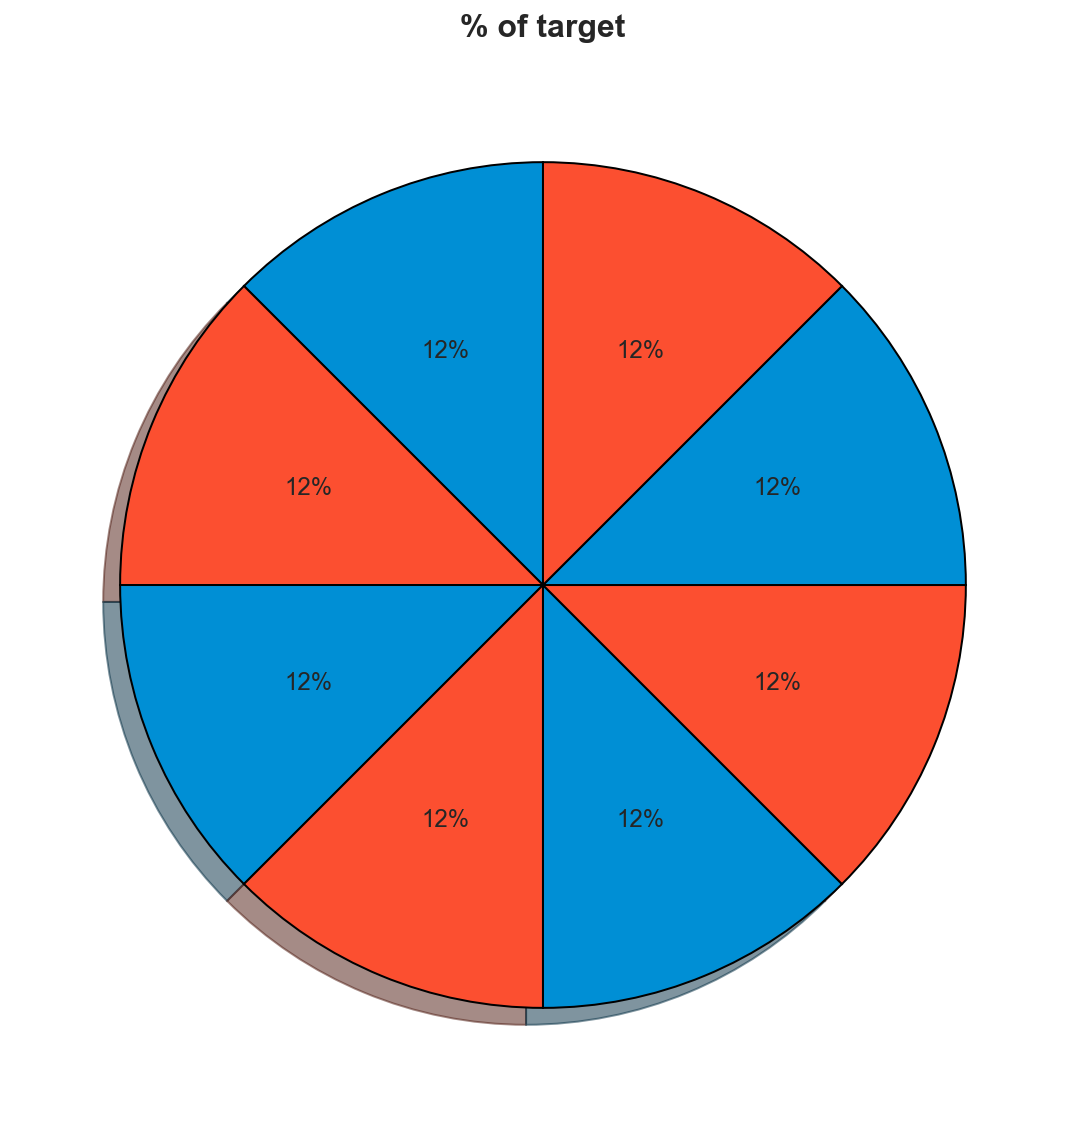

In [657]:
target_count = raw_df[TARGETNAME].value_counts().to_frame().T

colors = ['#008fd5', '#fc4f30']
plt.figure(figsize=(8,8))
plt.title('% of target')
plt.tight_layout()
plt.pie(list(target_count.iloc[0].values), startangle=90, wedgeprops={'edgecolor': 'black'}, colors=colors, autopct='%1.f%%', shadow=True)
plt.legend(loc='best', fontsize='medium')
plt.show()

In [658]:
X = raw_df.drop(['match_id'], axis=1)


In [659]:
y = X.pop(TARGETNAME)

In [660]:
X.fillna('', inplace=True)

In [661]:
X.dtypes

augment0               object
augment1               object
augment2               object
Set7_Bruiser          float32
Set7_Cannoneer        float32
                       ...   
TFT7_Aatrox_item1      object
TFT7_Aatrox_item2      object
TFT7_Senna_item1       object
TFT7_Senna_item2       object
TFT7_Skarner_item2     object
Length: 265, dtype: object

In [662]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

In [663]:
X[numeric_cols] = X[numeric_cols].applymap(np.int64)

In [664]:
matches_df = X.copy()
matches_df[TARGETNAME] = y

In [665]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Columns: 265 entries, augment0 to TFT7_Skarner_item2
dtypes: int64(87), object(178)
memory usage: 20.6+ MB


In [666]:
X

,augment0,augment1,augment2,Set7_Bruiser,Set7_Cannoneer,Set7_Dragon,Set7_Evoker,Set7_Guardian,Set7_Mage,Set7_Mystic,...,TFT7_Heimerdinger_item1,TFT7_Heimerdinger_item2,TFT7_Skarner_item1,TFT7_Senna_item0,TFT7_Sett_item2,TFT7_Aatrox_item1,TFT7_Aatrox_item2,TFT7_Senna_item1,TFT7_Senna_item2,TFT7_Skarner_item2
0,TFT6_Augment_Ascension,TFT6_Augment_TinyTitans,TFT6_Augment_Diversify3,1,1,1,1,1,0,0,...,,,,,,,,,,
1,TFT6_Augment_TradeSector,TFT7_Augment_BigFriend,TFT6_Augment_RadiantRelics,0,0,1,0,0,0,0,...,,,,,,,,,,
2,TFT6_Augment_RichGetRicher,TFT6_Augment_MakeshiftArmor1,TFT6_Augment_WindfallPlusPlus,1,0,0,0,0,0,0,...,,,,,,,,,,
3,TFT7_Augment_MikaelsGift,TFT6_Augment_Weakspot,TFT6_Augment_RadiantRelics,0,2,1,1,1,0,2,...,,,,,,,,,,
4,TFT6_Augment_ThrillOfTheHunt2,TFT7_Augment_Preparation,TFT7_Augment_CavalierEmblem2,0,0,0,0,0,0,0,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,TFT6_Augment_RichGetRicher,TFT7_Augment_DragonmancerInspire,TFT7_Augment_DragonmancerEmblem,0,0,0,0,0,0,0,...,,,,,,,,,,
10196,TFT7_Augment_CannoneerHotShot,TFT6_Augment_TargetDummies,TFT7_Augment_RevelPartyTime,0,1,1,1,1,0,1,...,,,,,,,,,,
10197,TFT6_Augment_ThrillOfTheHunt2,TFT7_Augment_MirageHallucinate,TFT7_Augment_UrfsGrabBag1,1,0,1,0,0,0,0,...,,,,,,,,,,
10198,TFT6_Augment_SalvageBin,TFT6_Augment_ThrillOfTheHunt2,TFT6_Augment_TomeOfTraits1,1,0,1,0,0,0,0,...,,,,,,,,,,


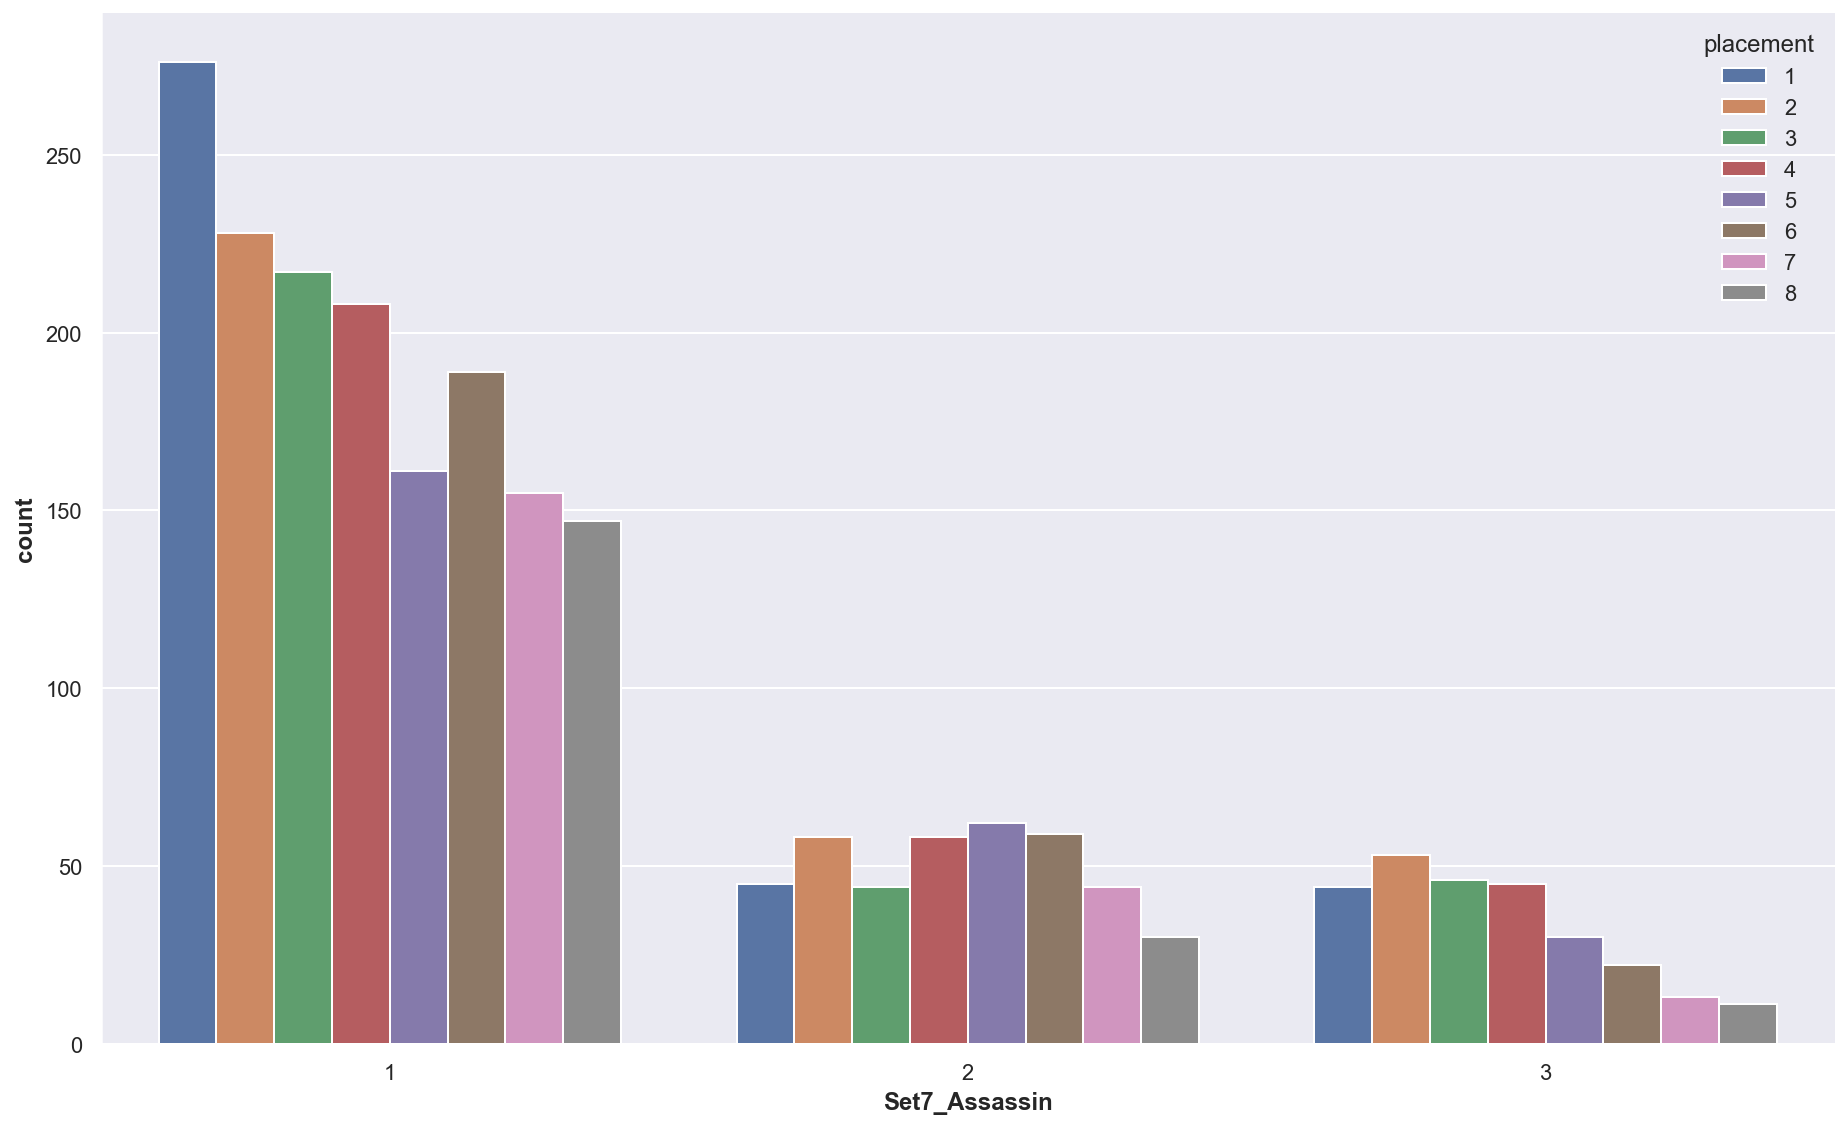

In [667]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Assassin']>0], x='Set7_Assassin', hue=TARGETNAME)
sns.despine()

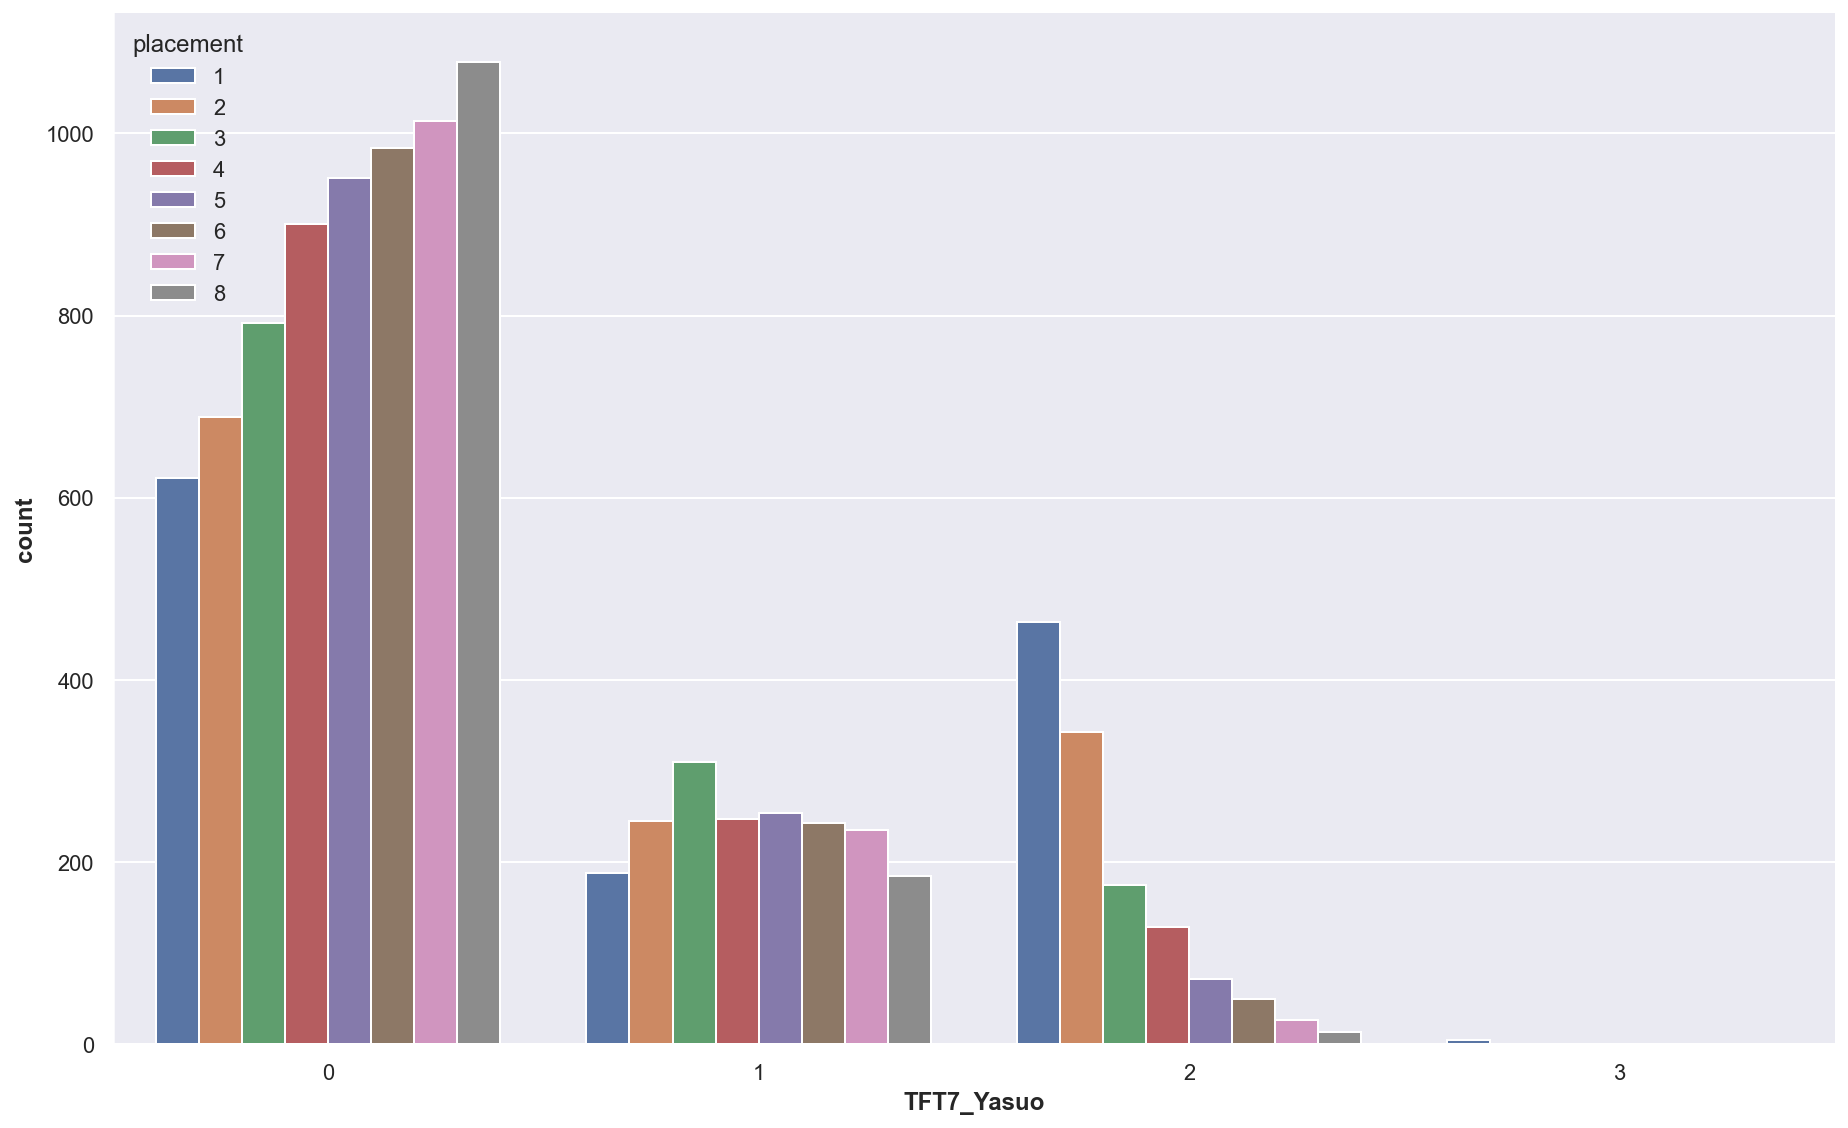

In [668]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='TFT7_Yasuo', hue=TARGETNAME)
sns.despine()

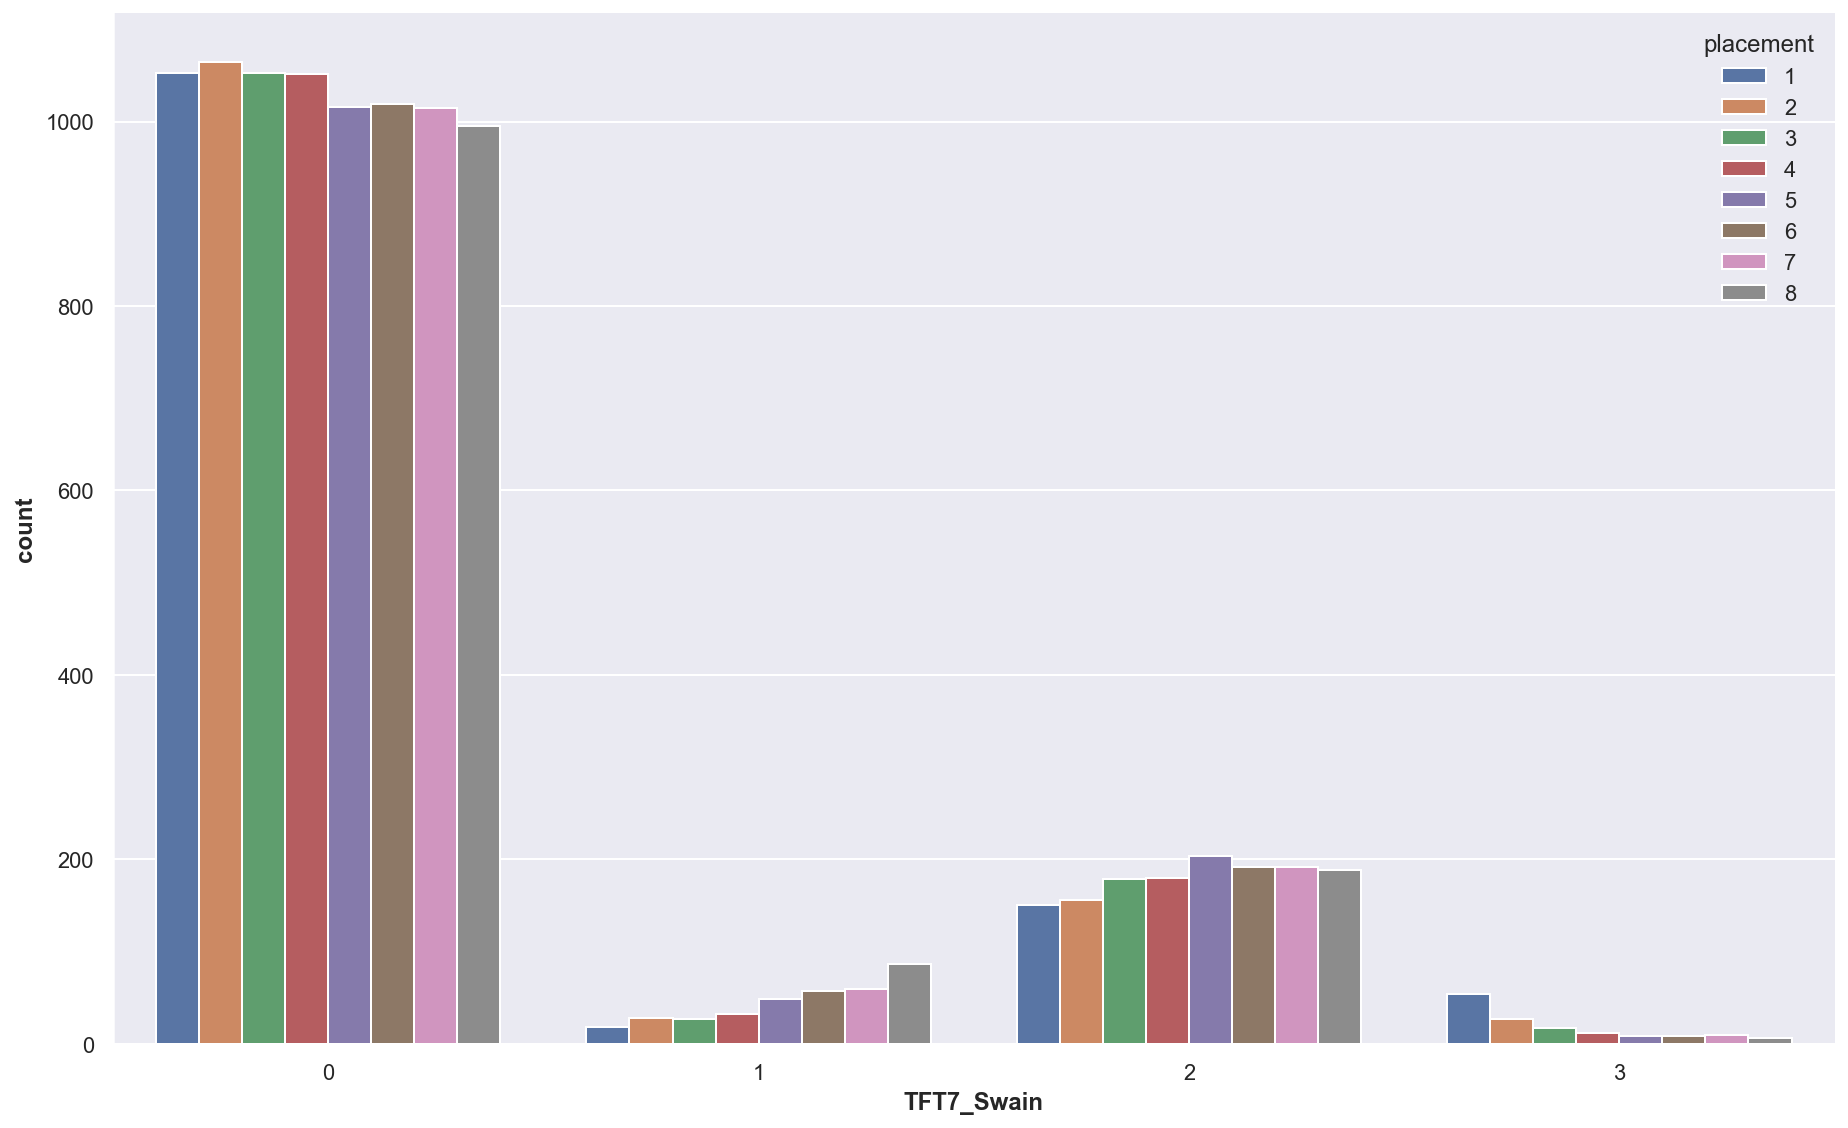

In [669]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='TFT7_Swain', hue=TARGETNAME)
sns.despine()

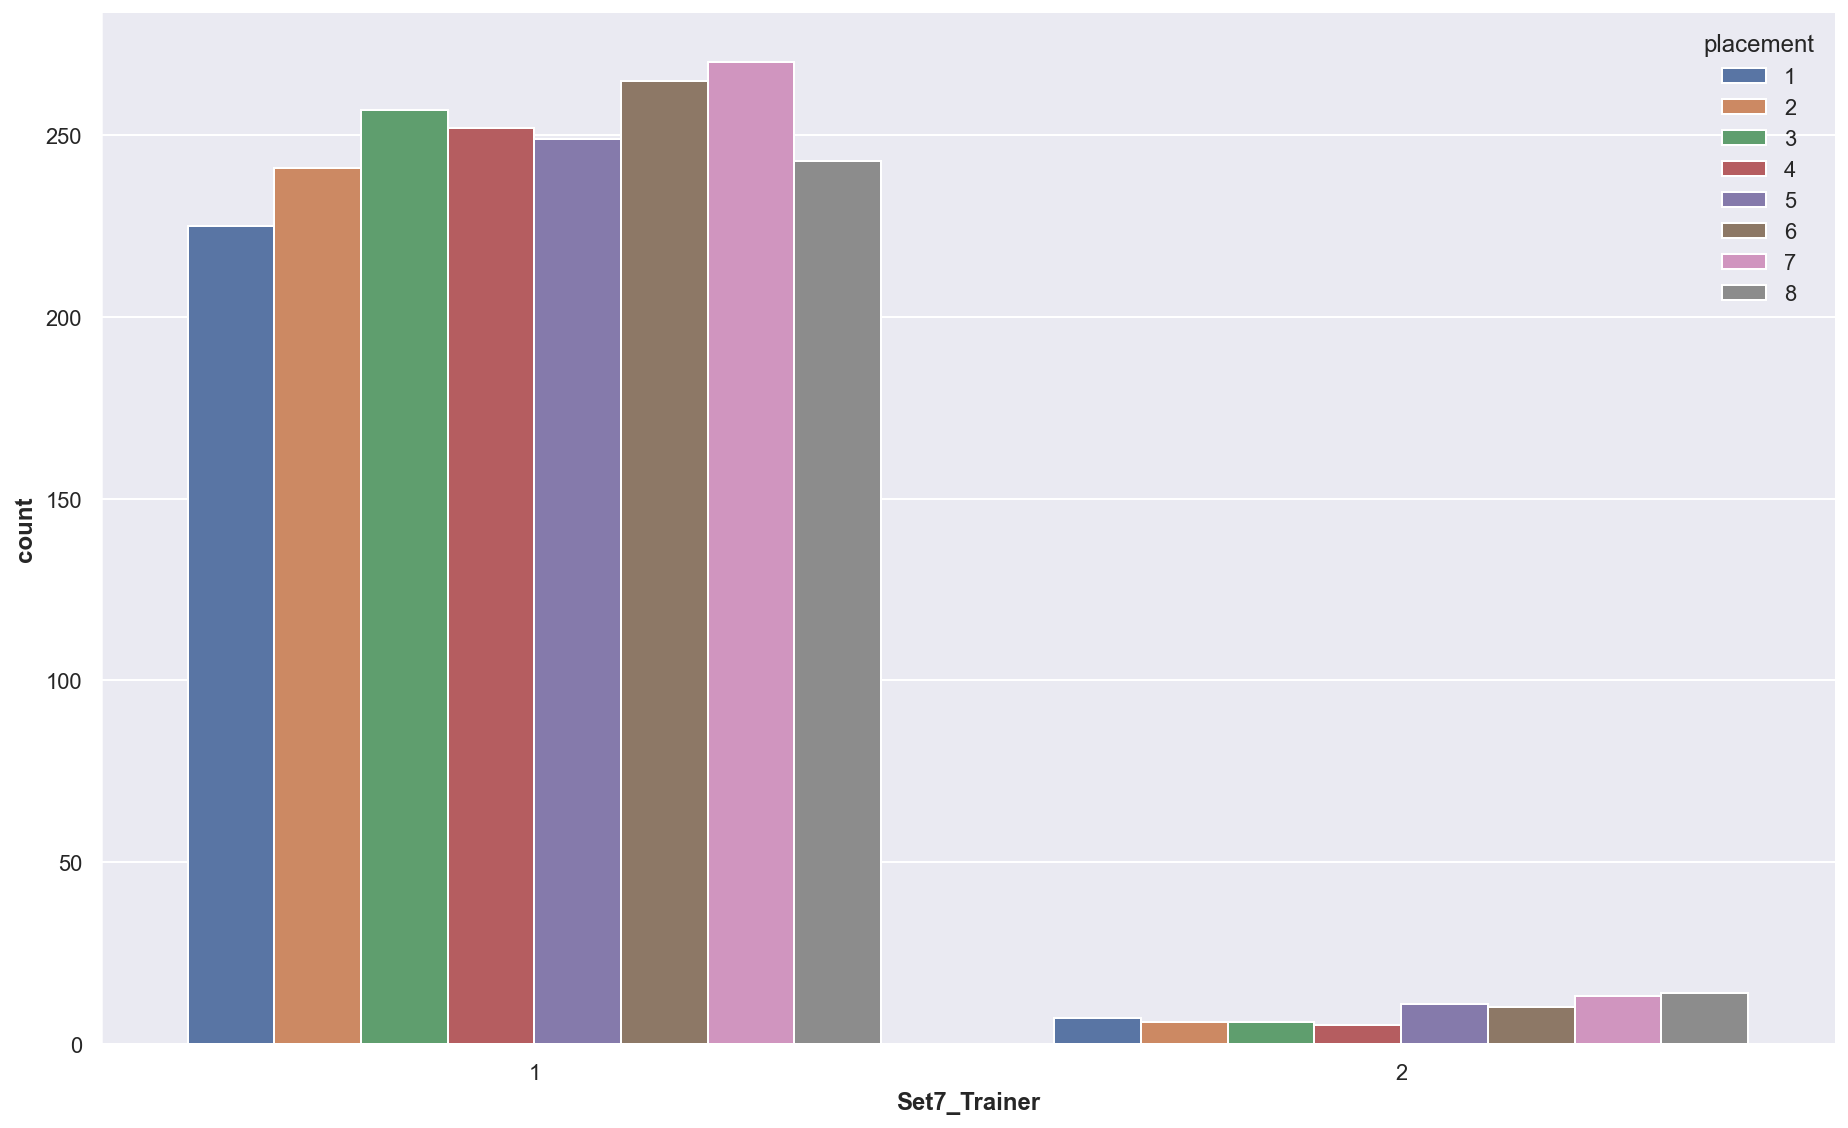

In [670]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Trainer']>0], x='Set7_Trainer', hue=TARGETNAME)
sns.despine()

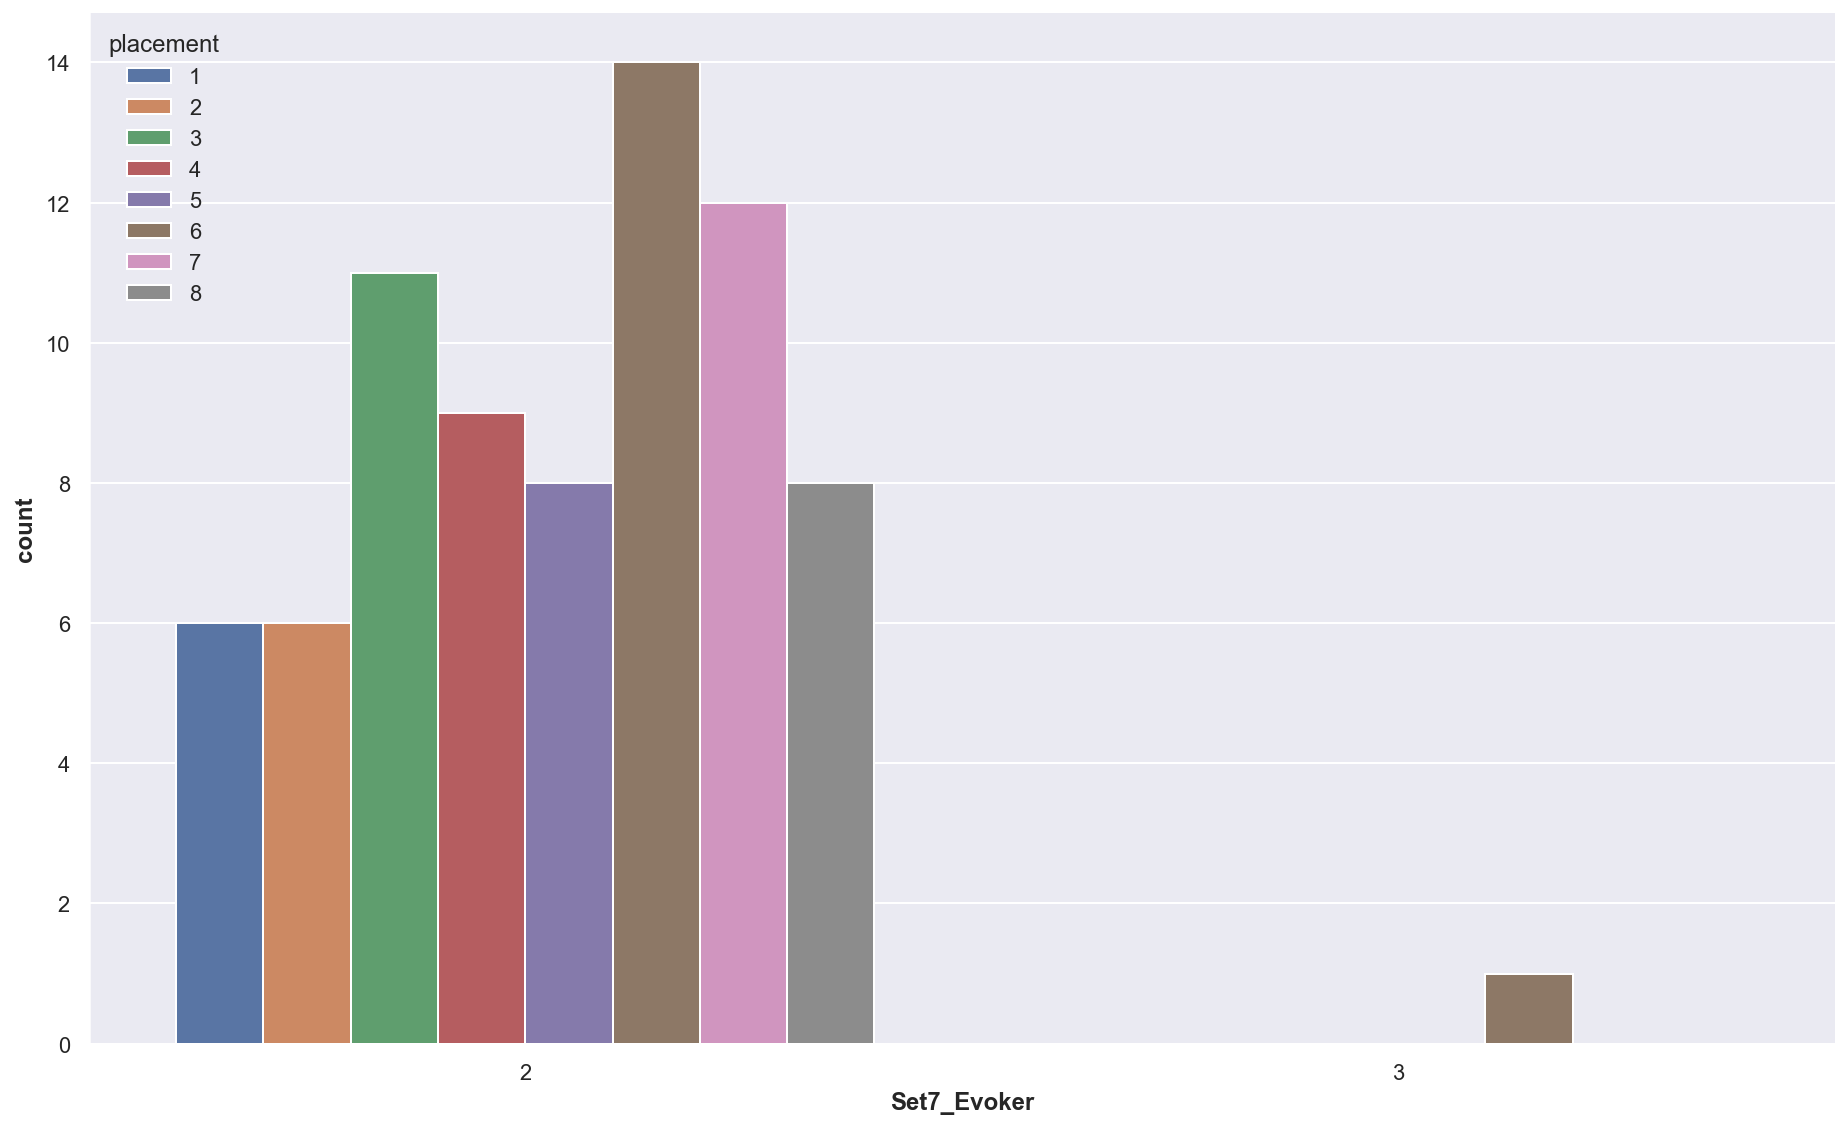

In [671]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Evoker']>1], x='Set7_Evoker', hue=TARGETNAME)
sns.despine()

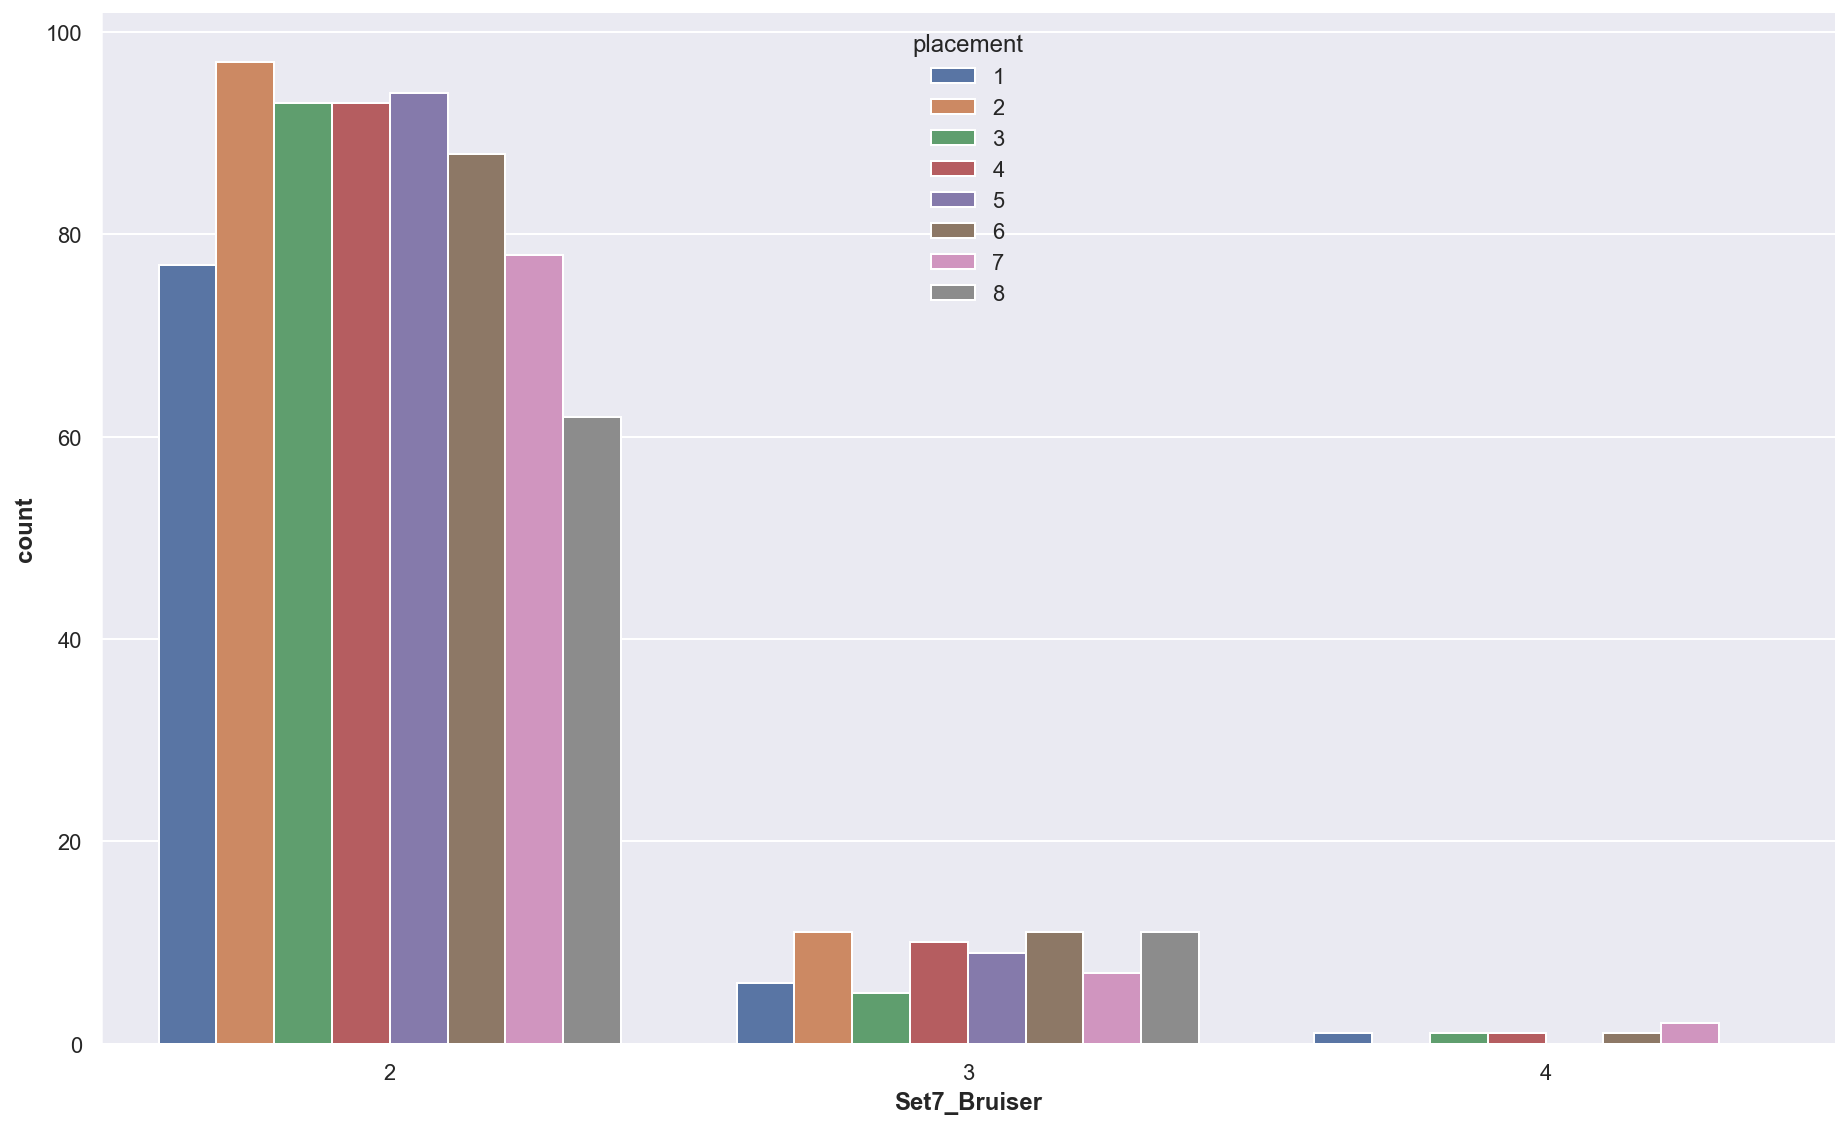

In [696]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Bruiser']>1], x='Set7_Bruiser', hue=TARGETNAME)
sns.despine()

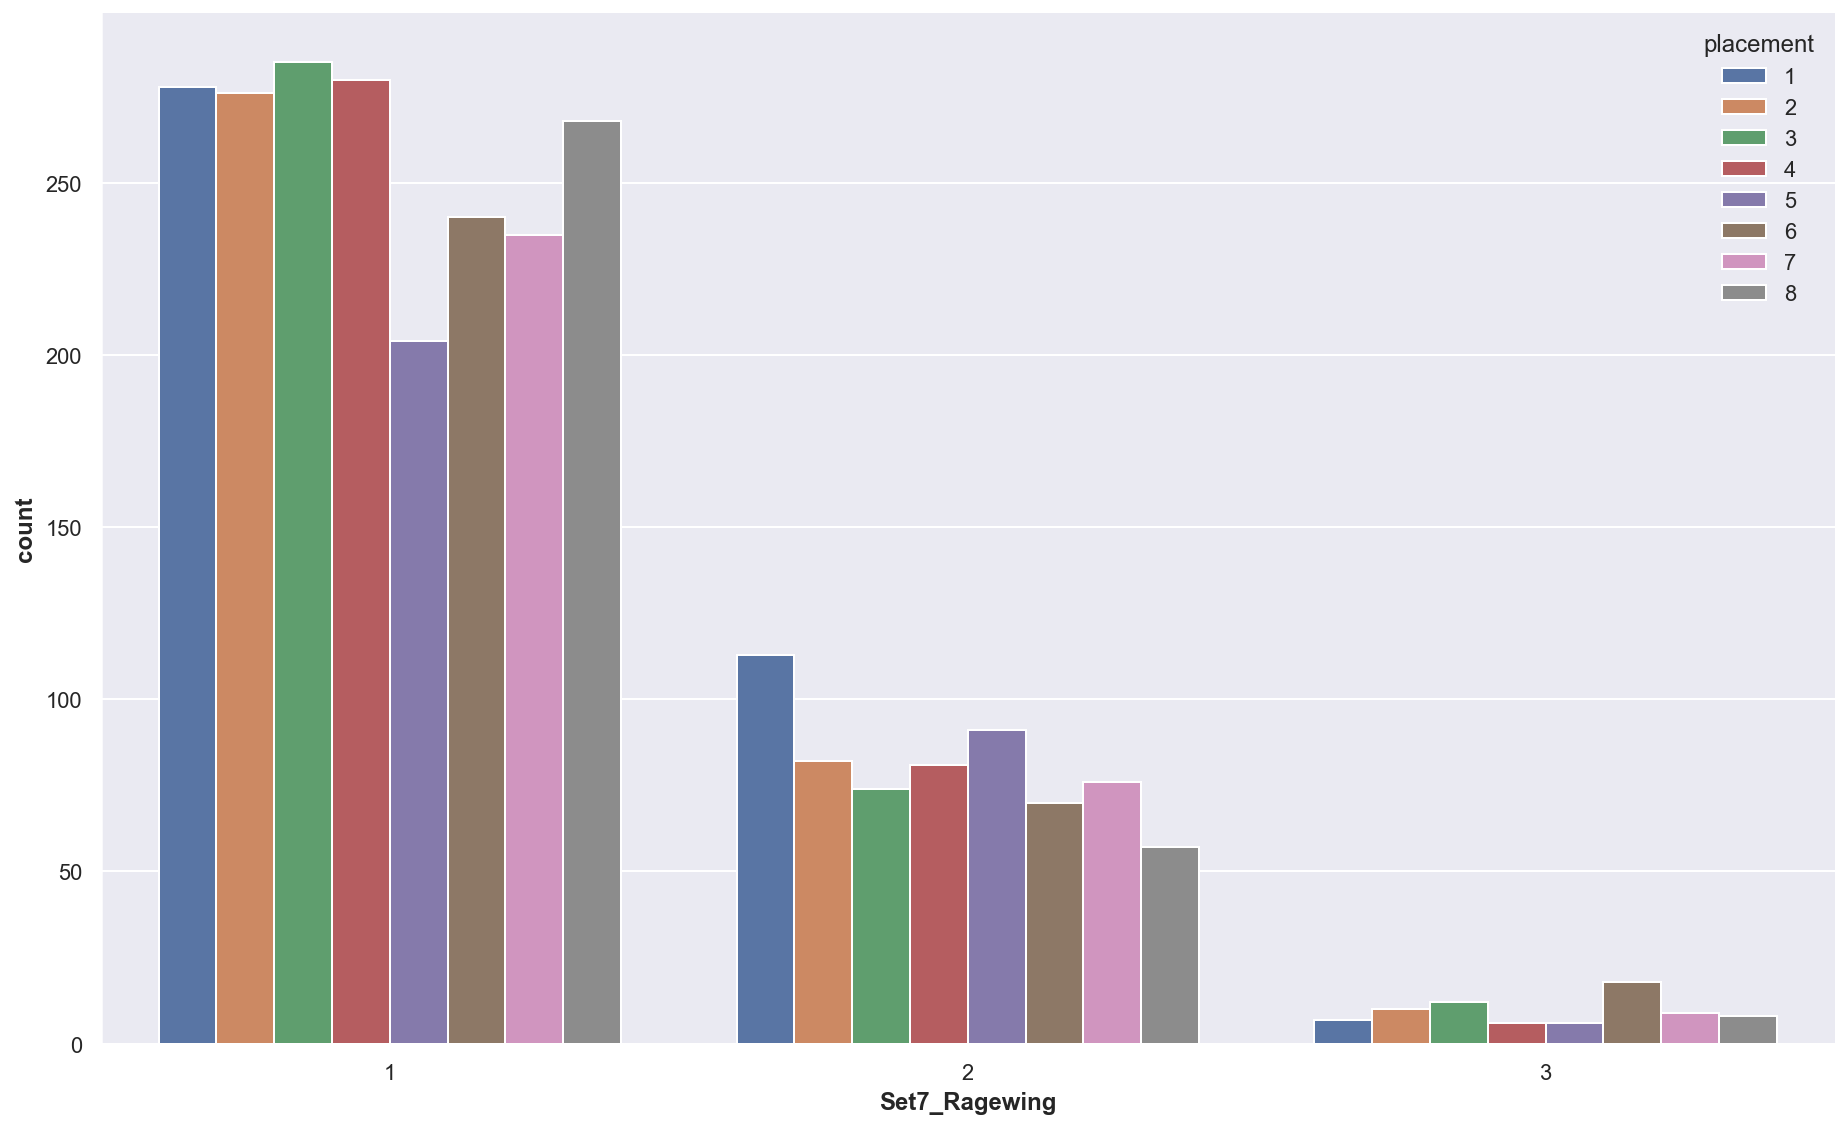

In [698]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Ragewing']>0], x='Set7_Ragewing', hue=TARGETNAME)
sns.despine()

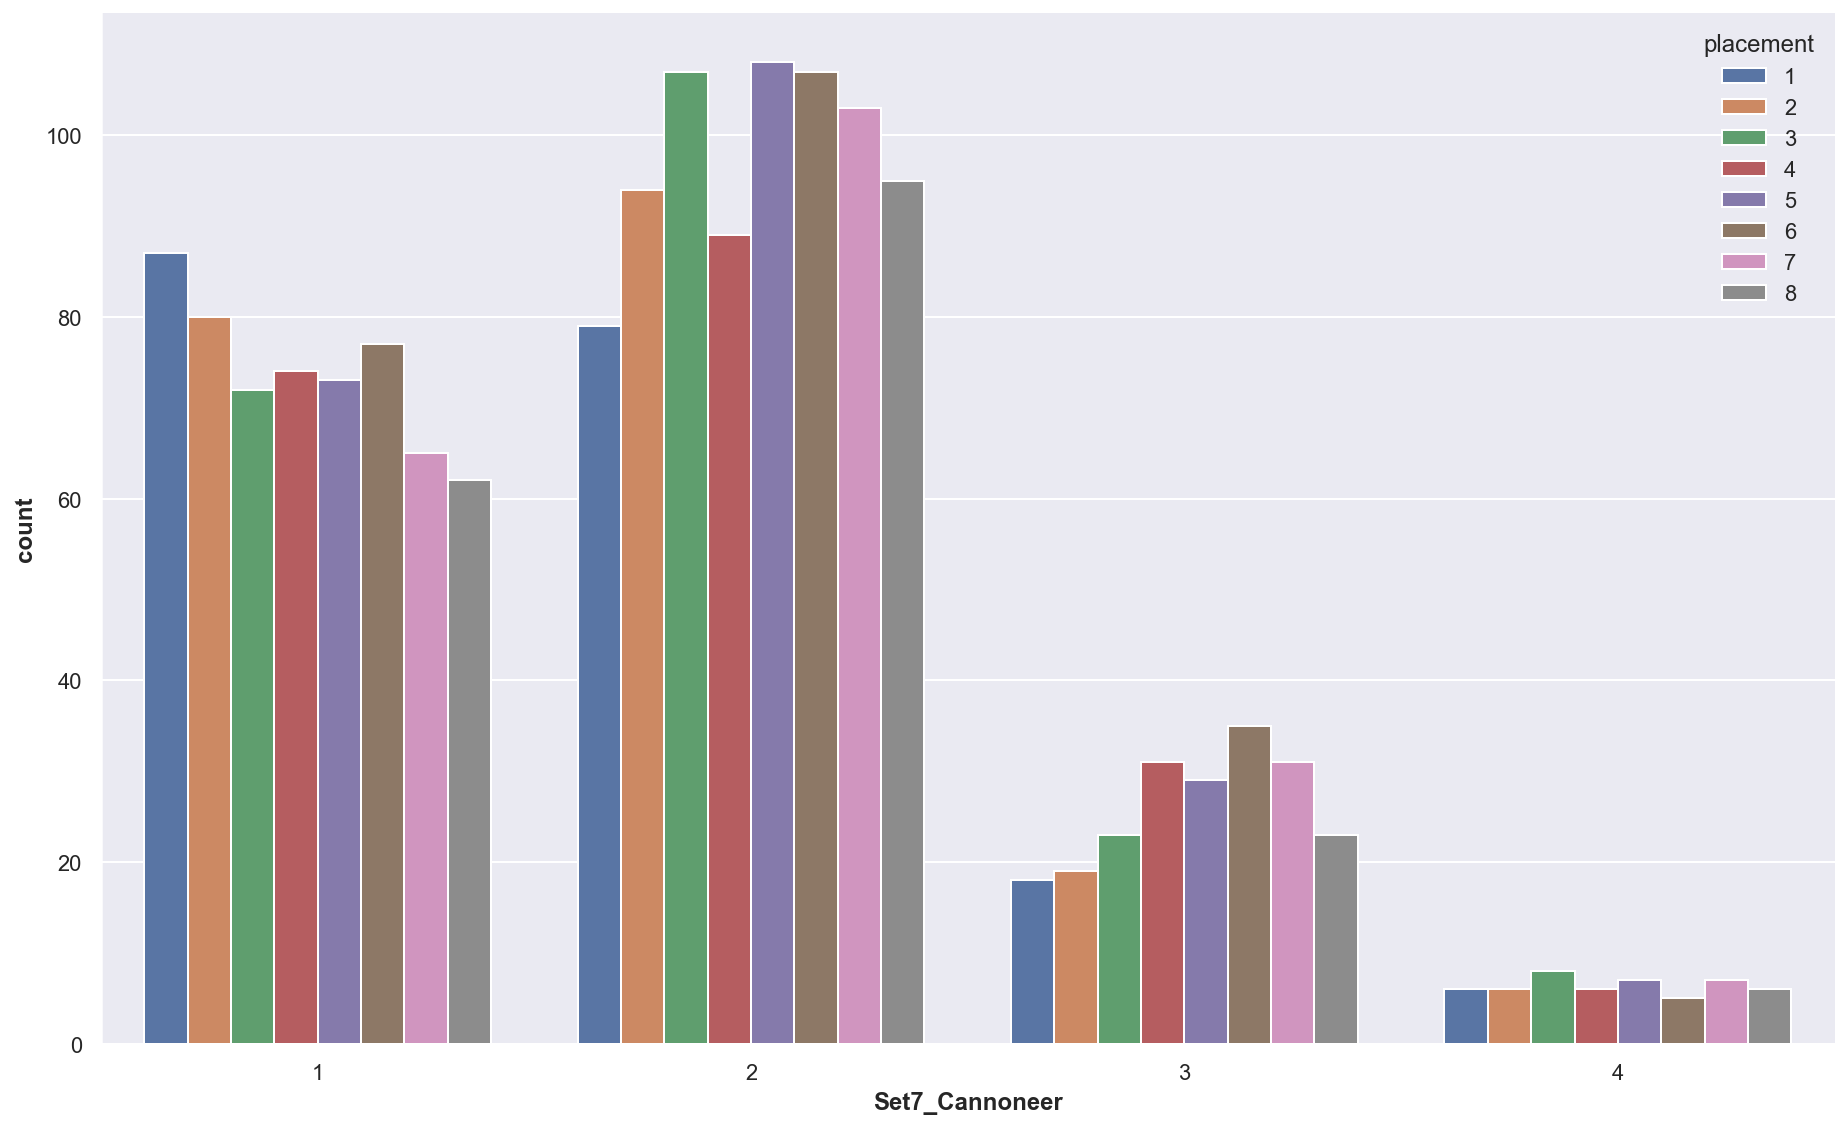

In [699]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Cannoneer']>0], x='Set7_Cannoneer', hue=TARGETNAME)
sns.despine()

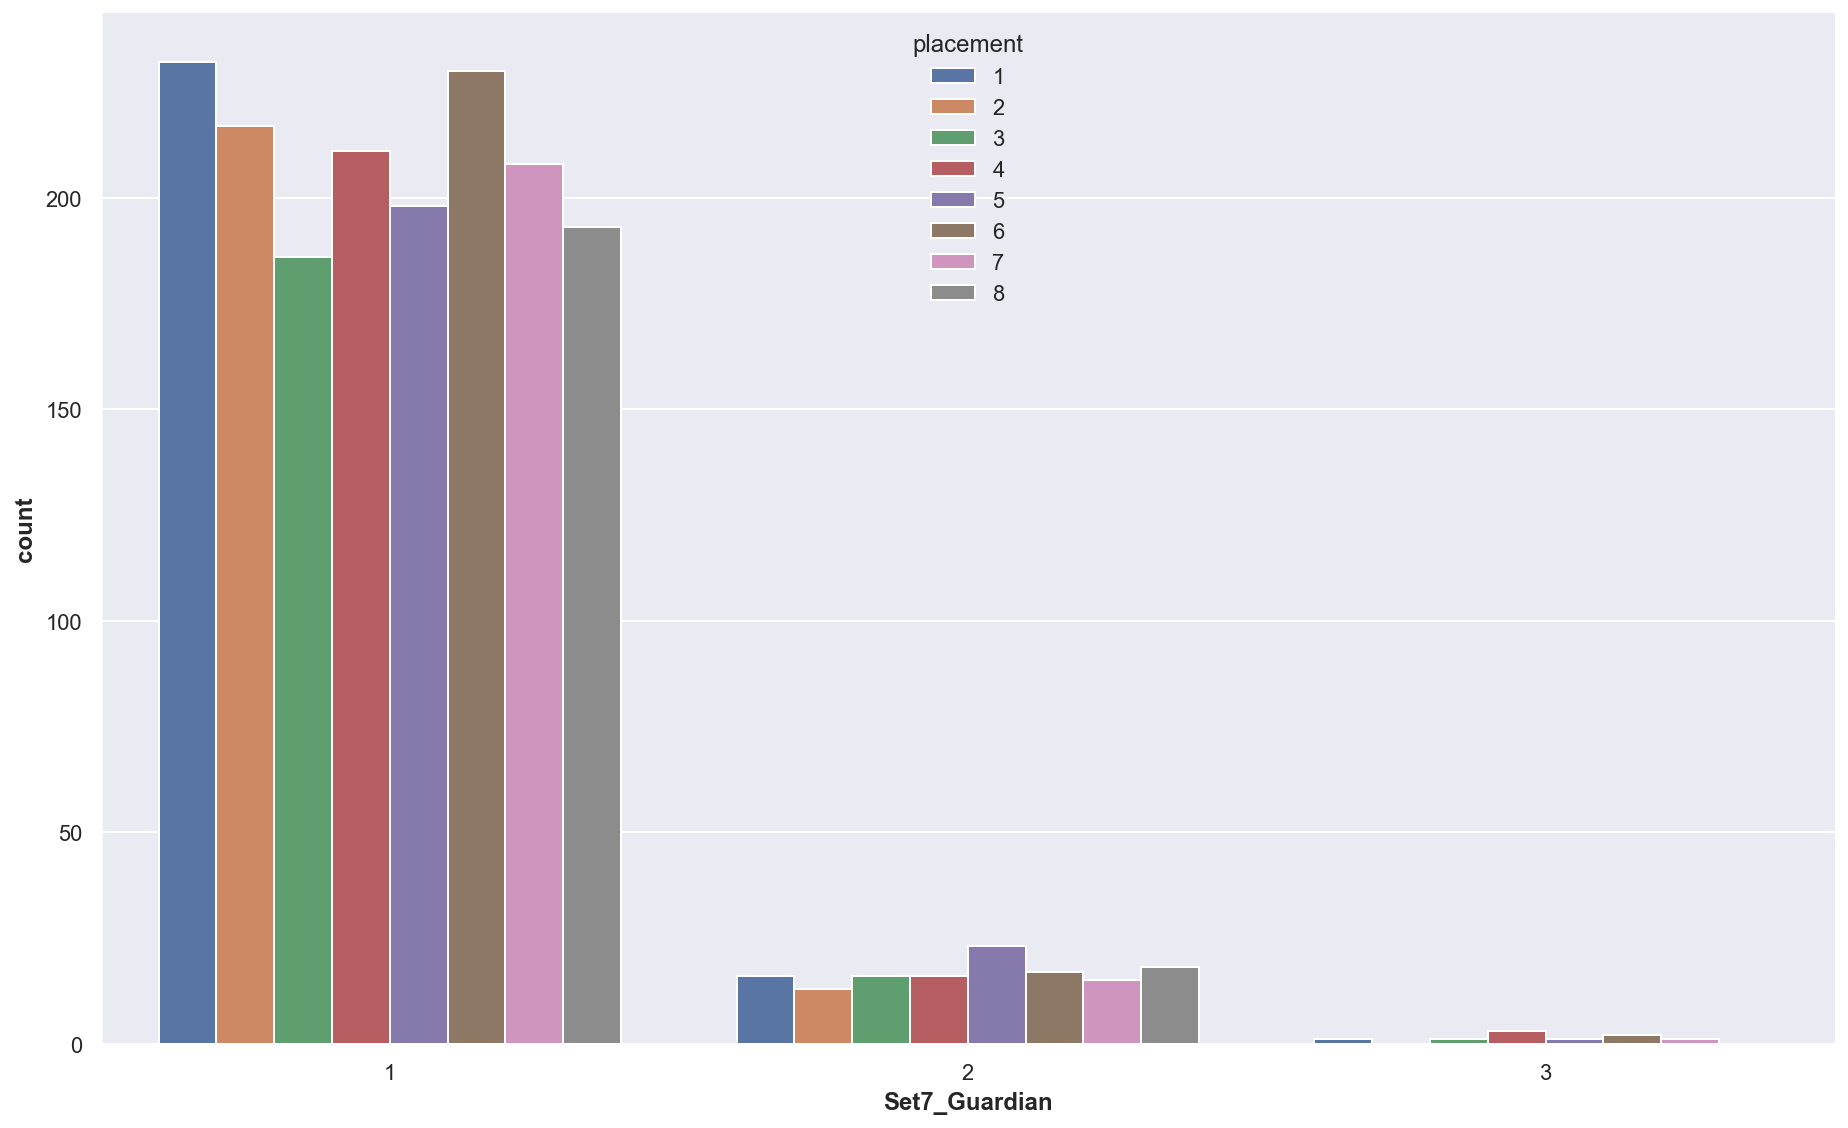

In [708]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Guardian']>0], x='Set7_Guardian', hue=TARGETNAME)
sns.despine()

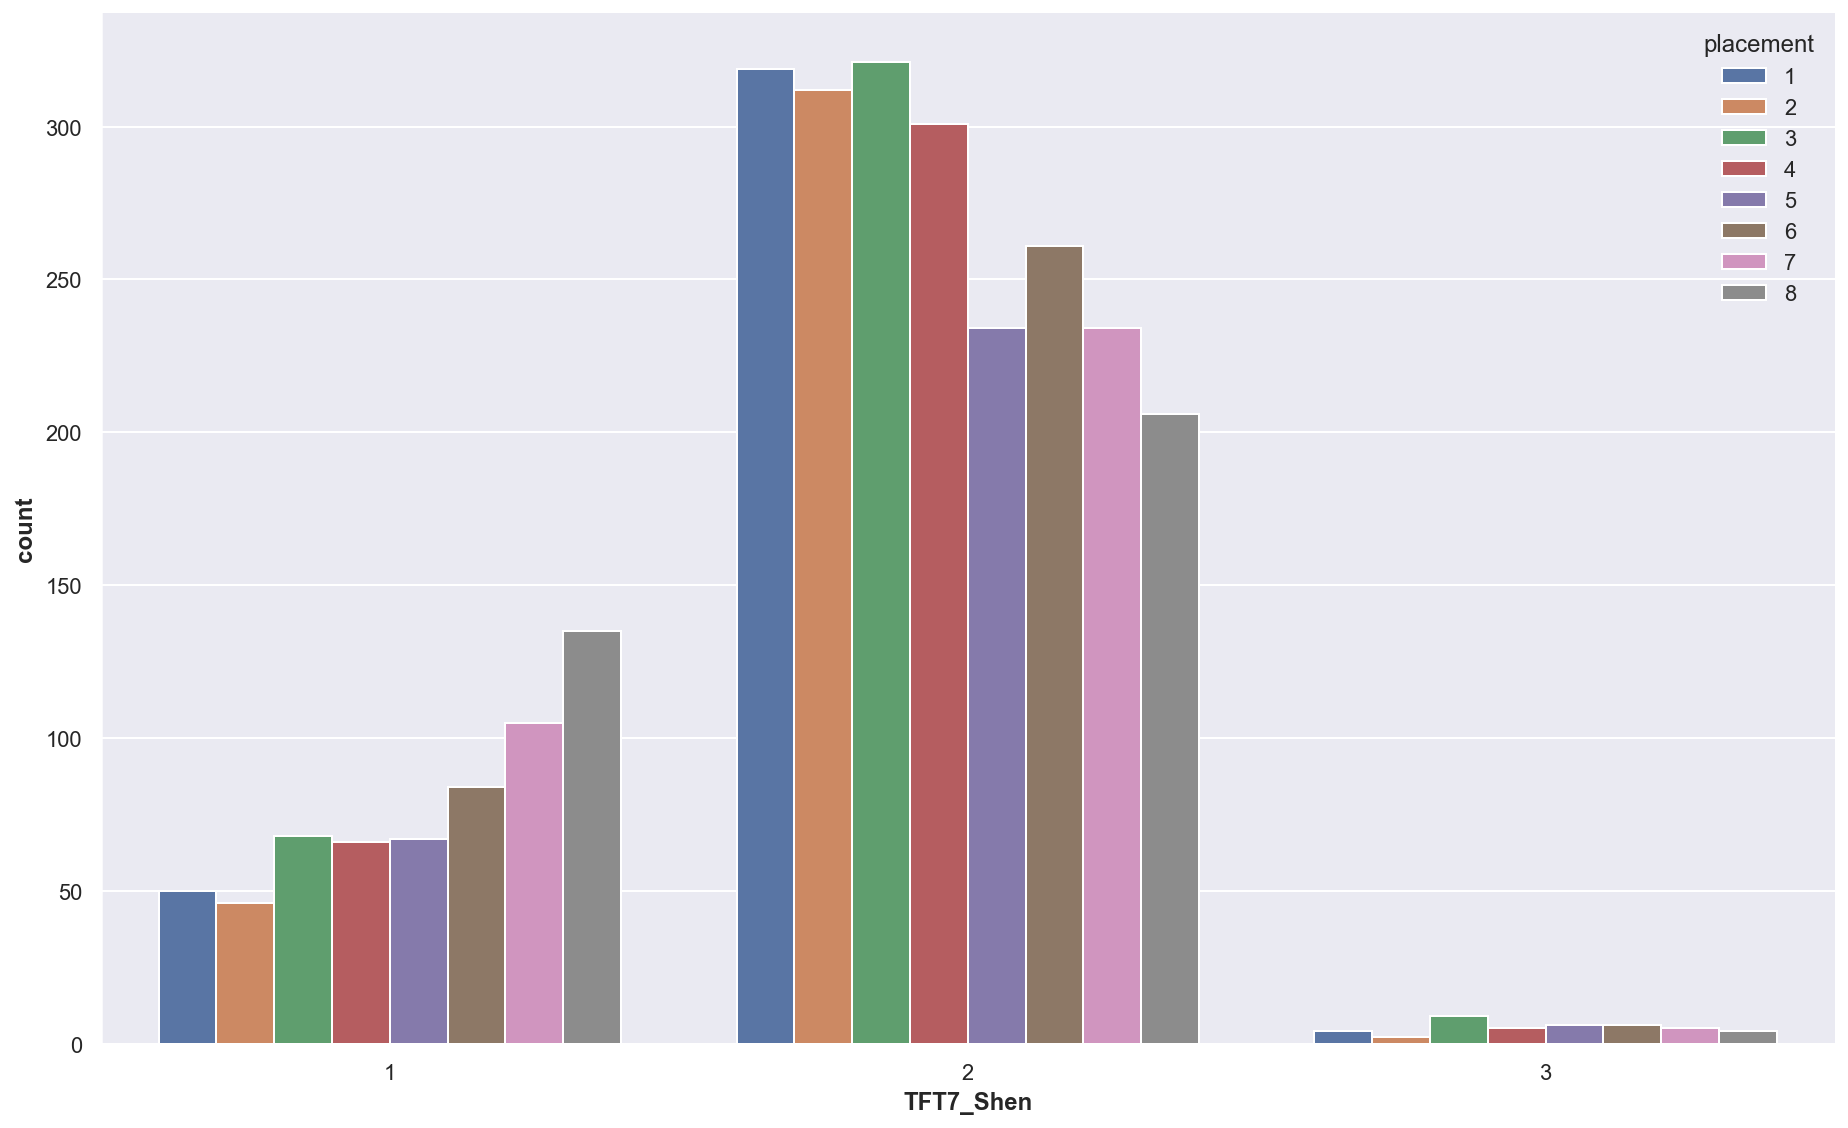

In [706]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['TFT7_Shen']>0], x='TFT7_Shen', hue=TARGETNAME)
sns.despine()

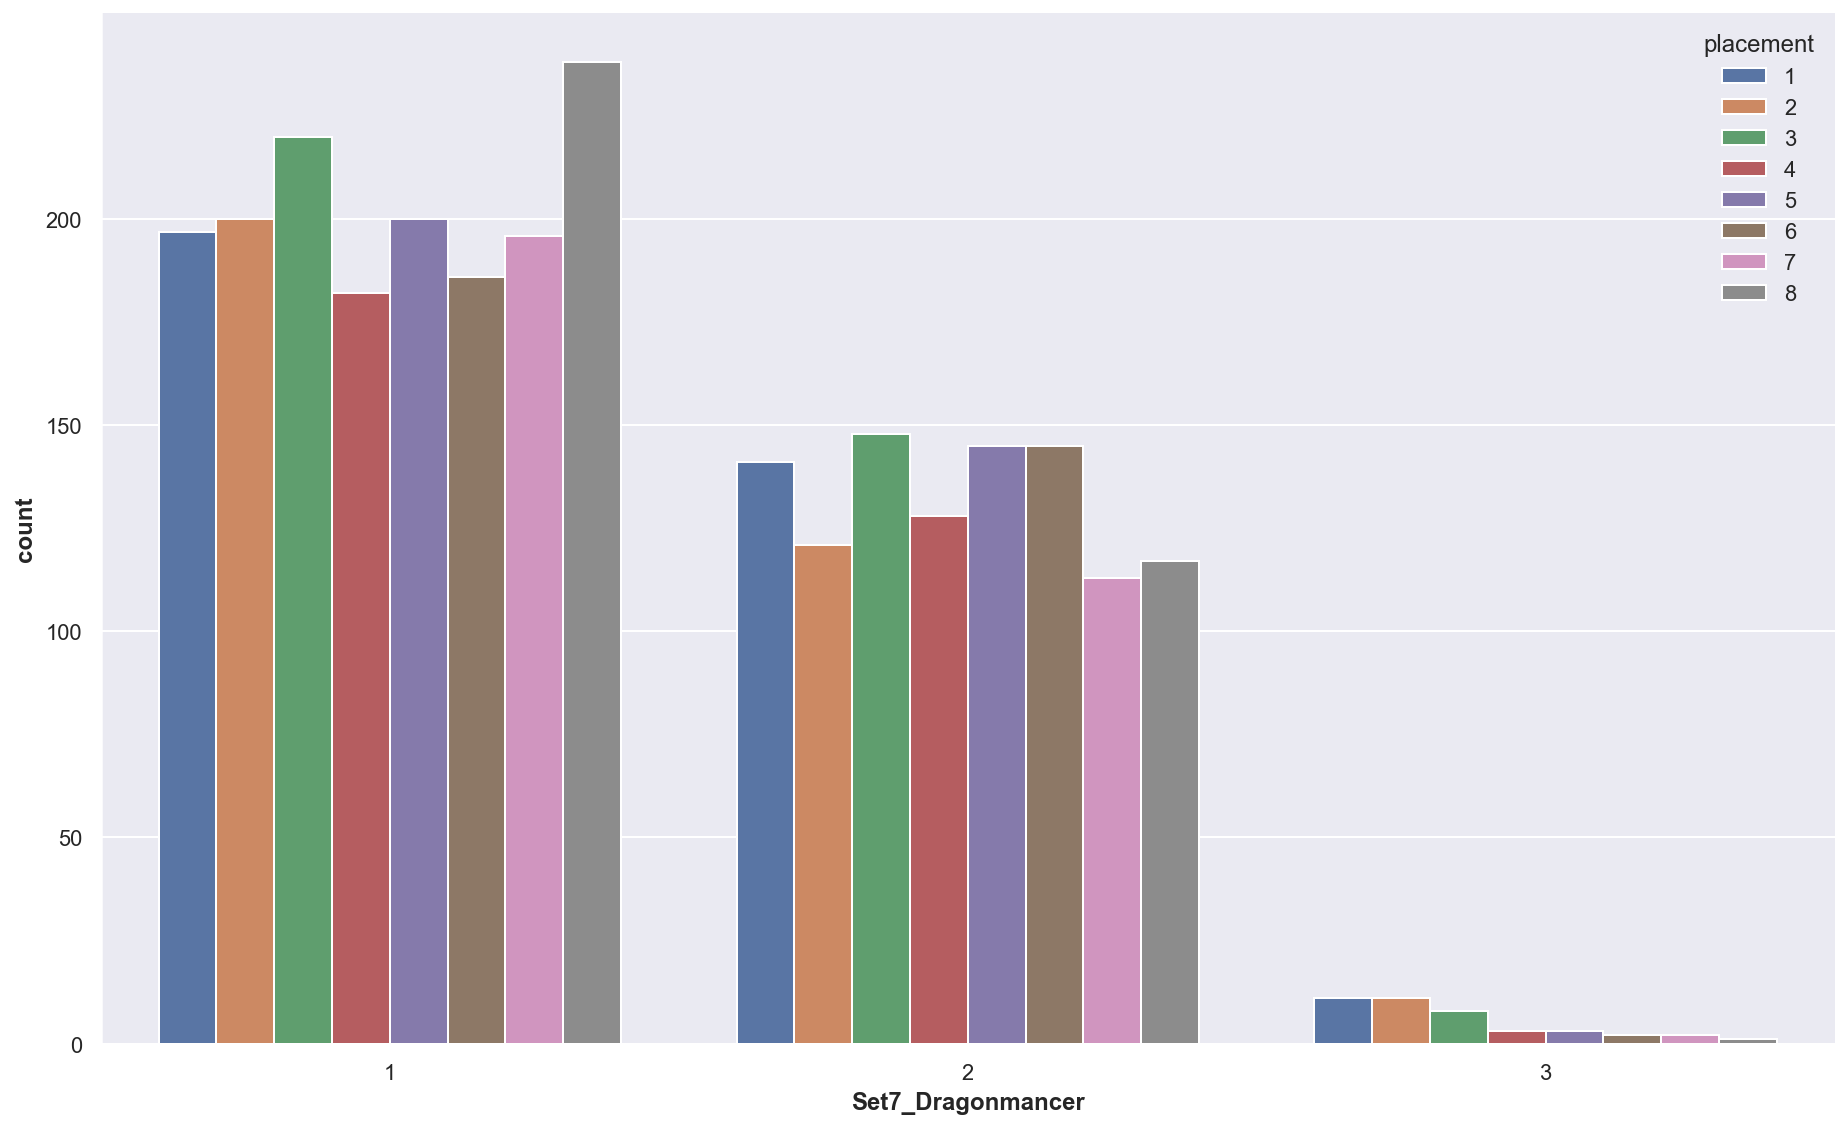

In [705]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['Set7_Dragonmancer']>0], x='Set7_Dragonmancer', hue=TARGETNAME)
sns.despine()

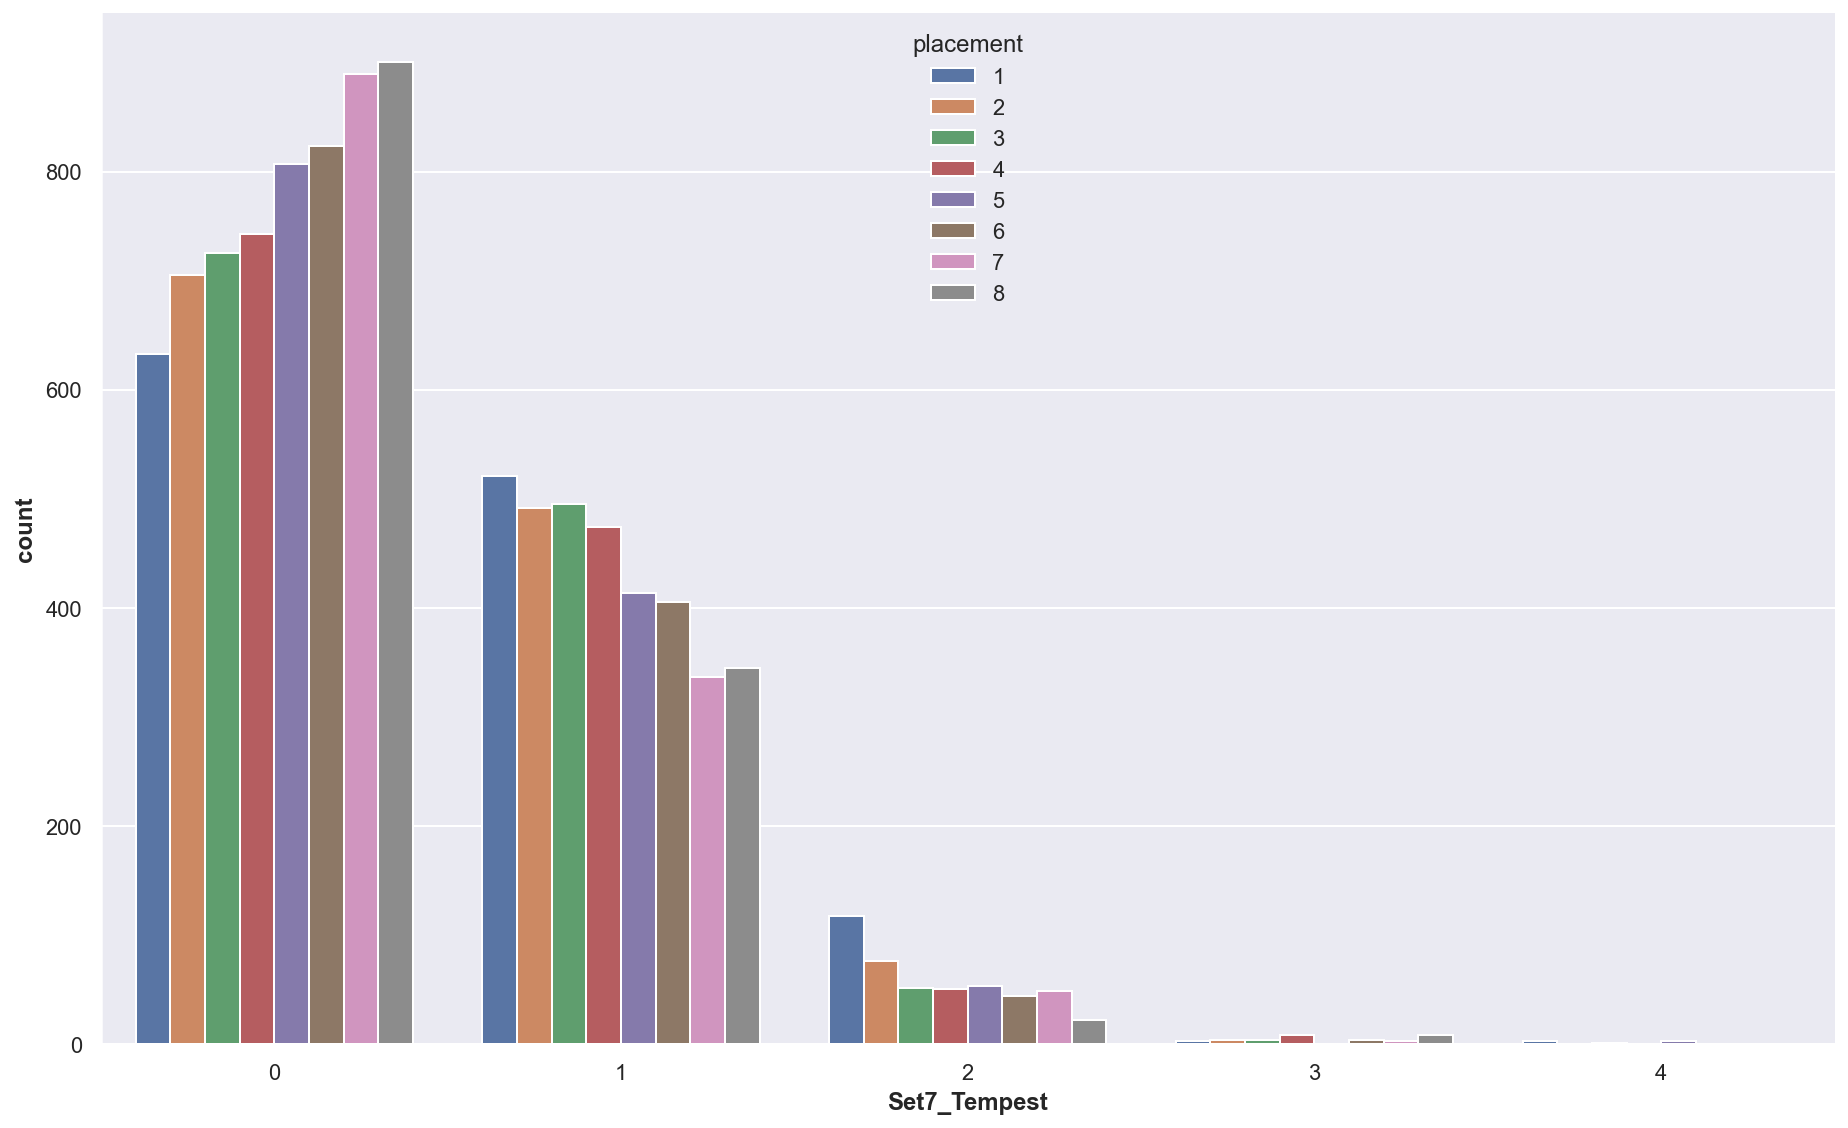

In [672]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df, x='Set7_Tempest', hue=TARGETNAME)
sns.despine()

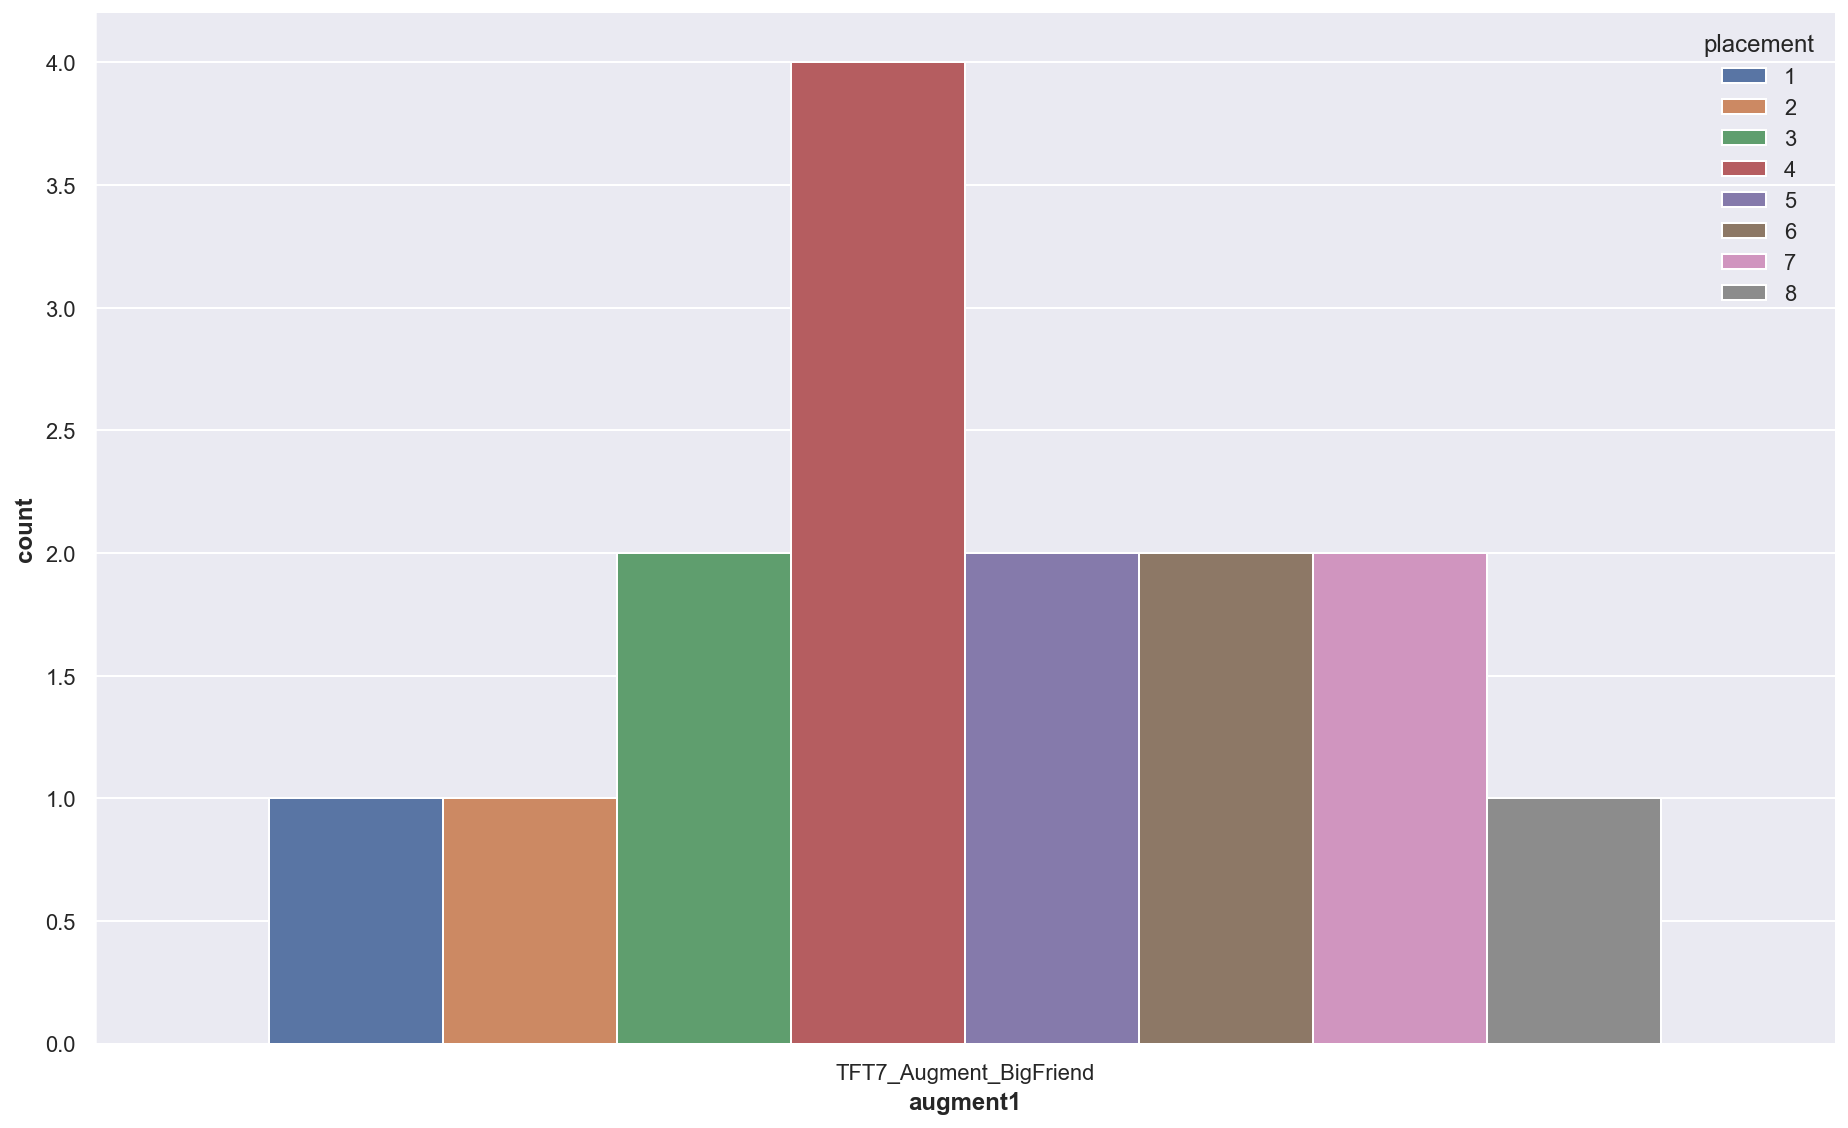

In [721]:
sns.set(rc={'figure.figsize':(13,8)})
sns.countplot(data=matches_df[matches_df['augment1']=='TFT7_Augment_BigFriend'], x='augment1', hue=TARGETNAME)
sns.despine()

In [673]:
# X[categorical_cols] = X[categorical_cols].applymap(np.int64)

In [674]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

In [675]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='mae', tree_method='hist',
                    n_estimators=250, enable_categorical=True) #, use_label_encoder=False hist

In [676]:
le_target = LabelEncoder()

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
augment_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
item_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
preproc = StandardScaler()

# Encode label. 0 = Show , 1 = No Show
y = le_target.fit_transform(y)

In [677]:
# augment_oe.fit(X[categorical_cols[:3]])

In [678]:
# item_oe.fit(X[categorical_cols[3:]])

In [679]:
# categorical_cols[3:]

In [680]:
# Encode category columns.
logistic_regression_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("one_hot_time", one_hot_encoder, categorical_cols),
            # ("augment", augment_oe, categorical_cols[:3]),
            # ("item", item_oe, categorical_cols[3:]),
        ],
        remainder=preproc,
        verbose_feature_names_out=False,
    ),
    xgb,
)

In [681]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.85, random_state=42)

logistic_regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('one_hot_time',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['augment0', 'augment1',
                                                   'augment2',
                                                   'TFT7_Shen_item0',
                                                   'TFT7_Shen_item1',
                                                   'TFT7_Tristana_item0',
                                                   'TFT7_Sylas_item0',
                                                   'TFT7_Corki_item0',
                                                   'TFT7_Corki_item1',
                                                   'TFT7_Corki_item2',
                                                   'TFT7_DragonGold_i...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=250, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [682]:
y_pred = logistic_regression_pipeline.predict(X_test)

In [683]:
def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis = 1 ),
        'precision': cm / cm.sum(axis = 0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout = True, figsize = (20,6))
    ax = ax.flatten()
#     mask = (np.eye(cm.shape[0]) == 0) * 1
    for idx, (name, matrix) in enumerate(metrics.items()):
        ax[idx].set_title(name)
        sns.heatmap(
            data = matrix,
            cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar = False,
#             mask=mask,
            lw = 0.25,
            annot = True,
            fmt = '.2f',
            ax = ax[idx]
        )
#         for tick in ax[idx].get_xticklabels():
#                 tick.set_rotation(60)
                
    sns.despine()
    
def plot_cm_error(cm):
    mask = (np.eye(cm.shape[0]) != 0) * 1
    fig, ax = plt.subplots(tight_layout=True, figsize=(15,8))
    sns.heatmap(
                data = pd.DataFrame(data=cm, index=le_target.classes_, columns = le_target.classes_),
#                 cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
                cbar = False,
                lw = 0.25,
                mask = mask,
                annot = True,
                fmt = '.0f',
                ax = ax
            )
    plt.xticks(rotation=45)
    plt.tight_layout()
    sns.despine()

In [684]:
# create confusion matrix, calculate accuracy,recall & precision
# cm = pd.DataFrame(data = confusion_matrix(le_target.inverse_transform(y_test), y_pred, labels = le_target.classes_), index = le_target.classes_, columns = le_target.classes_)
# plot_cm(cm)

In [685]:
len(y_test)

1530

In [686]:
y_pred.shape

(1530,)

In [687]:
def plot_oof(y_true, y_predict):
    # Plot y_true vs. y_pred
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_predict, s=3, color='r', alpha=0.5)
    plt.plot([plt.xlim()[0], plt.xlim()[1]], [plt.xlim()[0], plt.xlim()[1]], '--', color='k')
    plt.gca().set_aspect('equal')
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.title('OOF Predictions')
    plt.show()

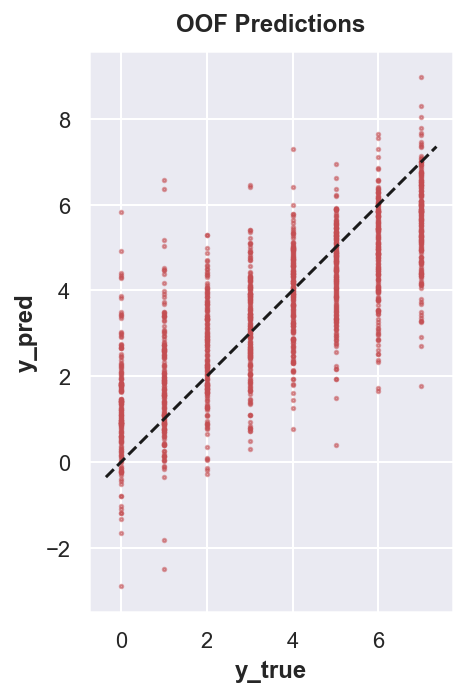

In [688]:
plot_oof(y_test, y_pred)

In [689]:
min(y_pred)

-2.889458

In [690]:
mean_absolute_error(y_test, y_pred)

1.1269327714561417

In [691]:
mean_squared_error(y_test, y_pred)

2.077883712542336

In [692]:
# logistic_regression_pipeline[:-1].get_feature_names_out()
feature_names = logistic_regression_pipeline[:-1].get_feature_names_out()
mdi_importances = pd.Series(
    logistic_regression_pipeline[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

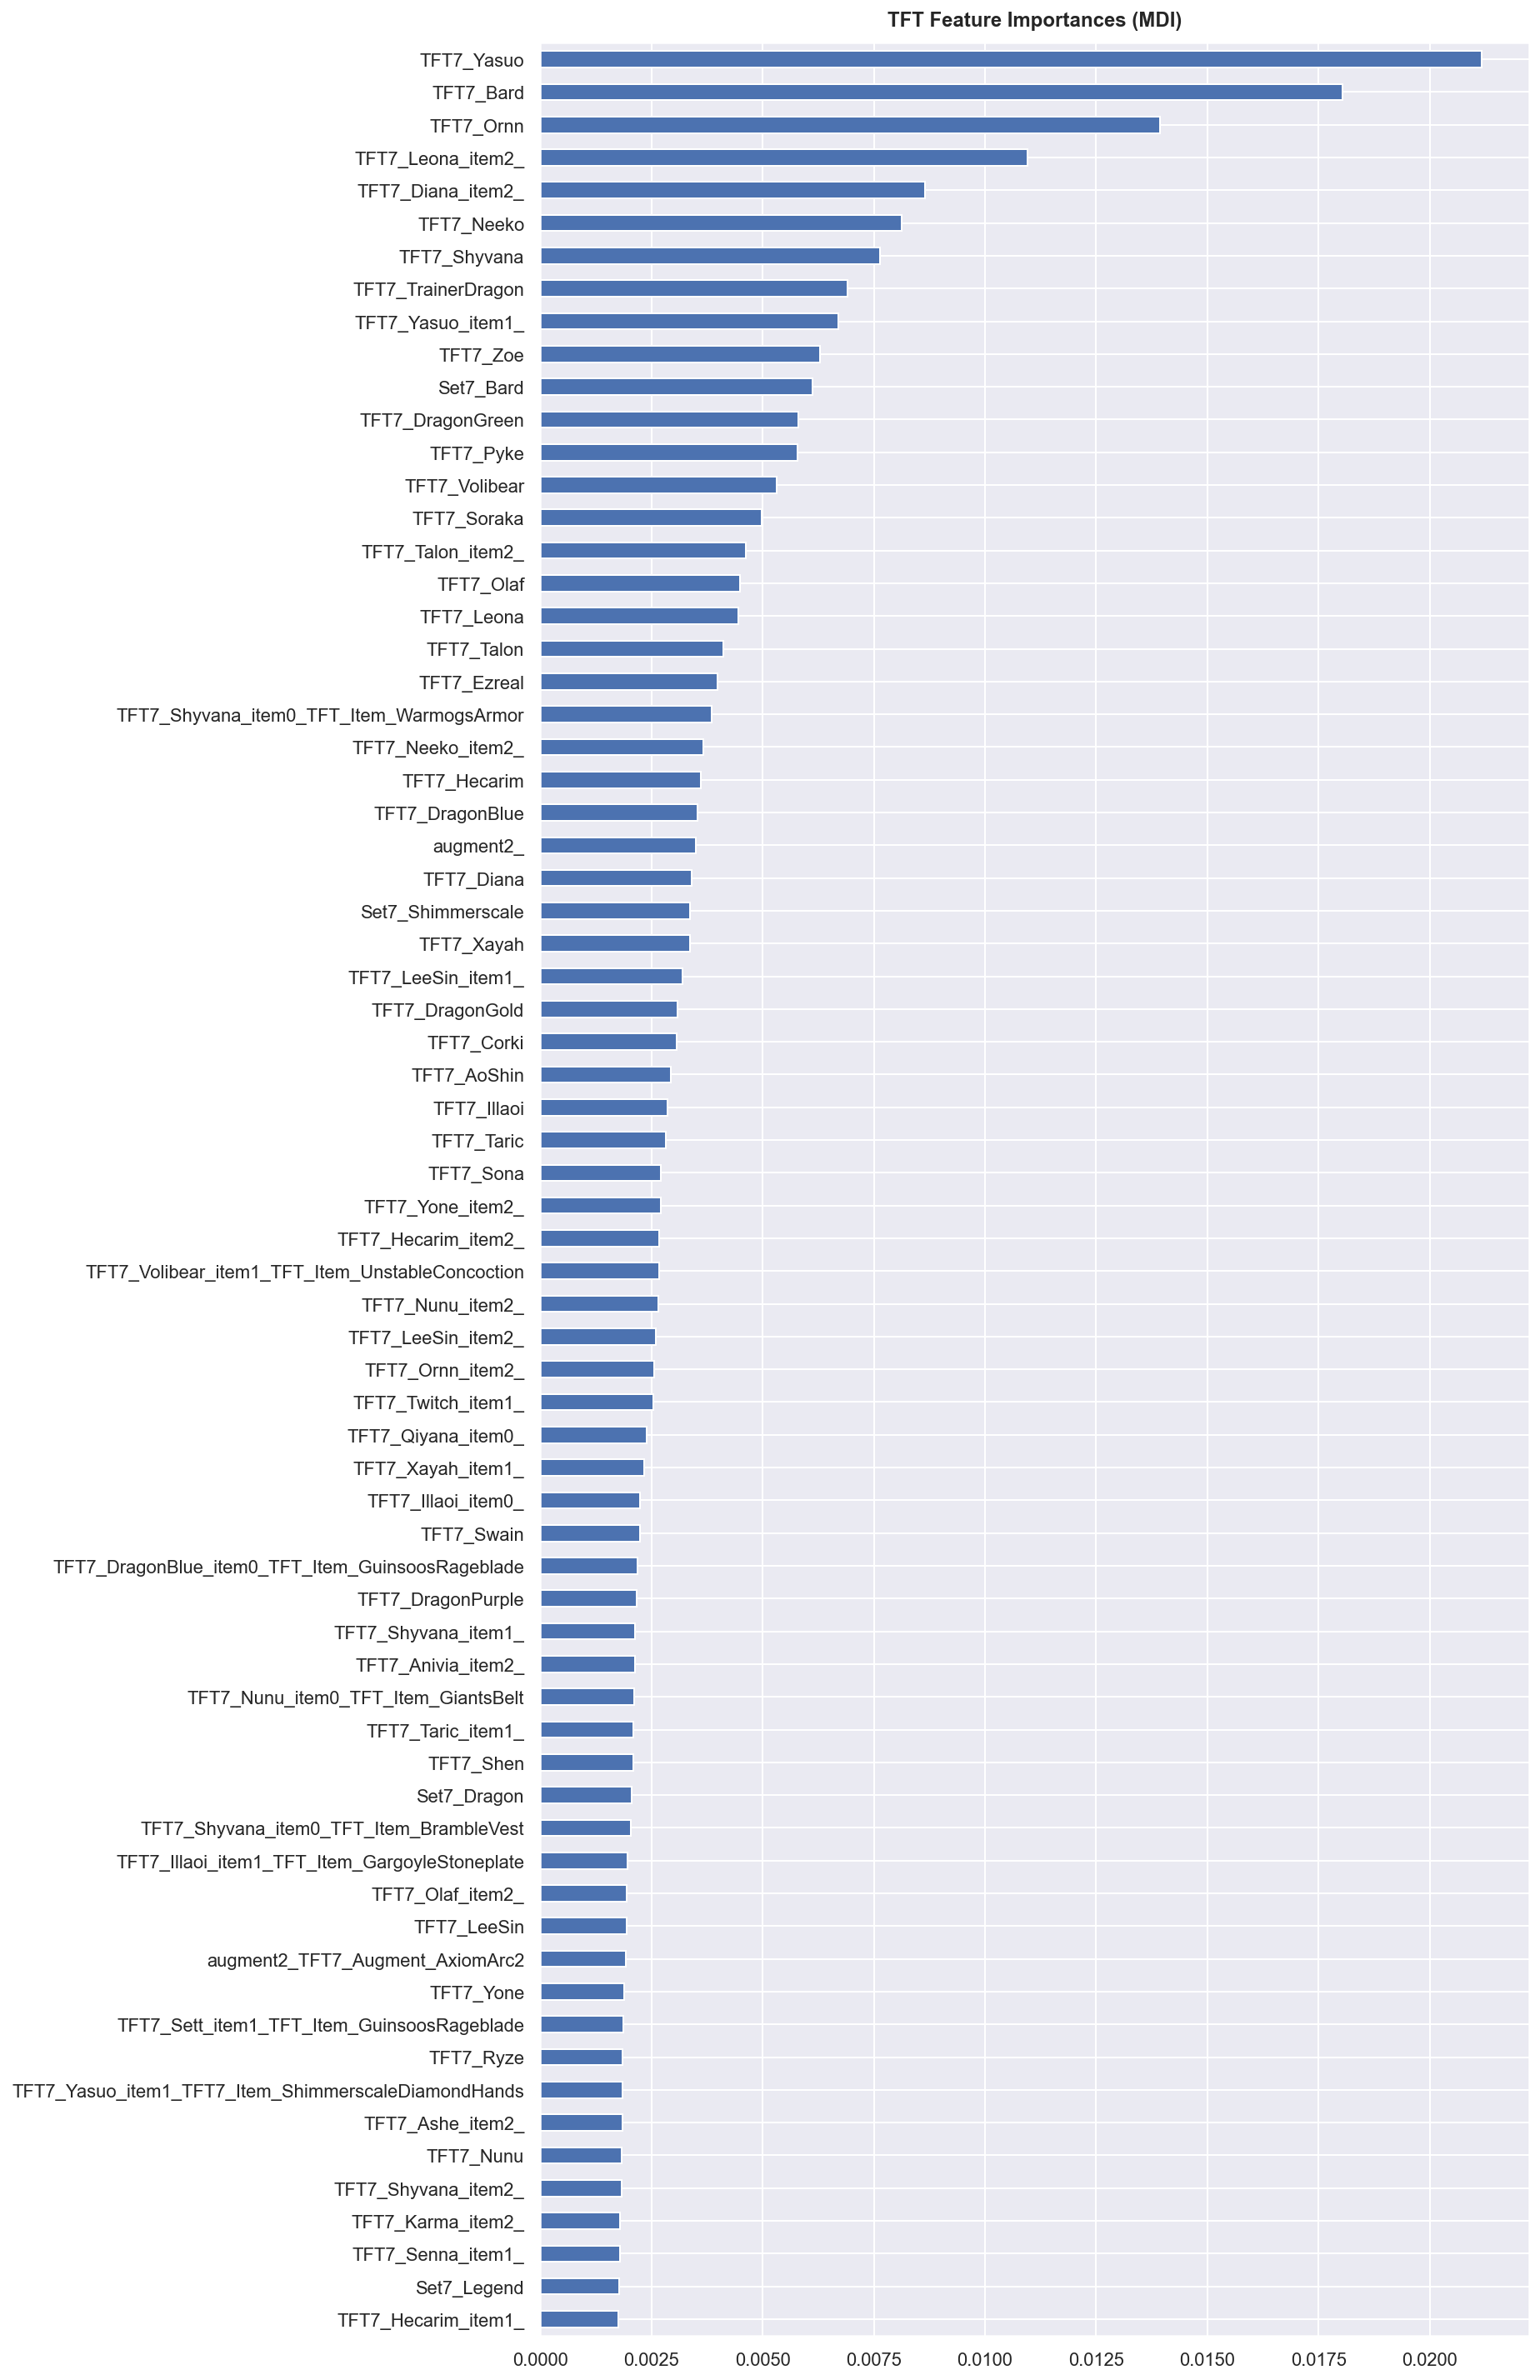

In [693]:
plt.figure(figsize=(13, 20))
ax = mdi_importances[-70:].plot.barh()
ax.set_title("TFT Feature Importances (MDI)")
ax.figure.tight_layout()

In [694]:
mdi_importances.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_mdi_importances.csv'))

In [695]:
mdi_importances[-60:]

TFT7_Yone                                           0.001895
augment2_TFT7_Augment_AxiomArc2                     0.001927
TFT7_LeeSin                                         0.001948
TFT7_Olaf_item2_                                    0.001950
TFT7_Illaoi_item1_TFT_Item_GargoyleStoneplate       0.001966
TFT7_Shyvana_item0_TFT_Item_BrambleVest             0.002043
Set7_Dragon                                         0.002059
TFT7_Shen                                           0.002094
TFT7_Taric_item1_                                   0.002098
TFT7_Nunu_item0_TFT_Item_GiantsBelt                 0.002109
TFT7_Anivia_item2_                                  0.002122
TFT7_Shyvana_item1_                                 0.002125
TFT7_DragonPurple                                   0.002162
TFT7_DragonBlue_item0_TFT_Item_GuinsoosRageblade    0.002187
TFT7_Swain                                          0.002235
TFT7_Illaoi_item0_                                  0.002235
TFT7_Xayah_item1_       